# CIS 5450 Final Project - Boston Rideshare Analytics
## *Graham Branscom, Mahika Calyanakoti*
## Spring 2024

## SECTIONAL SUMMARY

### Introduction and Background

With the rise of rideshare companies revolutionizing transportation in today's world, and with college students being a primary target customer base, we sought to analyze the various factors impacting the costs of these services by analyzing a Kaggle dataset on rideshare data from Boston, Massachusetts. With information on rides from Uber and Lyft, the two biggest rideshare companies in America, along with weather data based on the ride’s location and time, this rich dataset allowed us to build complex models to gain business and consumer insights to see how the companies perform in comparison, and how consumers (especially students) can understand the pricing factors behind their favorite transportation services.

Goals:


1.   Derive novel insights from this
comprehensive dataset on what factors, both direct (such as rideshare company, distance, and time) and indirect (such as preciptation and temperature), impact the price of a given ride (regressional analysis).
2.   Determine if we can construct a model that classifies rides as either Uber or Lyft (classification analysis)?
3.   Use our model results to paint a multi-dimensional picture of the ridesharing business landscape.


Overview of the dataset: We have 693,000 observations of rides and 57 features describing the ride along with weather data based on the location and time of the ride, such as source, destination, distance, time, precipitation, and more. Our target variables are price (regression) and cab company (classification).

EDA Highlights: We found Lyft has higher prices on average, and the overall average price is $16. We also found from our map visualization that the high traffic, higher priced rides are from North End and North Station. We further found that temperature affects price in a bell curve pattern, and that the peak demand of rides are around noon and midnight. Lastly, we found that special ride types caused great differences in prices, such as higher prices for luxury types (Uber Black SUV, Lyft Lux) and cheaper prices for UberPool and Lyft Shared.

### Approach/Methods

Class Topics Used: Regex, Pandas, PandaSQL, Supervised, Unsupervised

Difficulty: Feature importance, feature selection, visualization packages (folium), imbalance data, hyperparameter tuning

Models: PCA clustering, Regression (unregularized and regularized), Feedforward Neural Network, Random Forest

First, we cleaned our data by removing highly correlated variables (using a correlation matrix), using one-hot encodings for categorical variables, and dropping outliers and nulls. We thenn used PCA for dimensionality reduction since we had a lot of variables, and we used clustering after picking the top few PCAs (using a PVE plot) to see any difference between Uber and Lyft rides. For improved complexity and interpretability, we used a Random Forest, using grid search for hyperparameter tuning and Accuracy/Recall/Precision metrics for performance evaluation. We also used feature importance to see what factors affected our random forest's prediction of company. For regression, we started with multiple linear regression without penalties for interpretable results and to find impact on price. We then used grid search for hyperparameter tuning to select between Ridge, Lasso, and Elastic Net regularized regression models, finding Ridge to perform the best. We then tried to use a feedforward neural network with linear layers and ReLU activation for increased power and ability to test feature interactions, but found it didn't perform better than the regression models.

See results and conclusions throughout the notebook and in sections 9 and 10.

## Part 0: Introduction

How do you get from point A to point B? It used to be that people would just hop in their cars, plug their destination into the GPS, and drive. But with the rise of rideshare companies revolutionizing transportation in today's world, and with college students being a primary target customer base, we sought to analyze the various factors impacting the costs of these services.

Our final project analyzes a [dataset](https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma) from Kaggle on rideshare data from Boston, Massachusetts. The dataset includes information about rides from both Uber and Lyft, the two biggest rideshare companies in America. The dataset also includes weather data that was merged with the rideshare information based on the hour and location of the ride.


With over 693,000 observations and 57 features, including the time, day, source, destination, distance, location, and rideshare company, this rich dataset provides a multi-dimensional picture of the ridesharing landscape.

In this project, we aim to derive novel insights from this comprehensive dataset on what factors, both direct (such as rideshare company, distance, and time) and indirect (such as preciptation and temperature), impact the price of a given ride (regressional analysis). We also sought to deepen our analyses by seeing if we could construct a model that classifies rides as either Uber or Lyft (classification analysis). Our notebook below walks you through an EDA of the dataset, linear regressions and a feedforward neural network to predict price, PCA and clustering as well as random forests to classify by company, visualizations, and error analysis. We conclude with written analyses summarizing our insights and detailing their impacts.

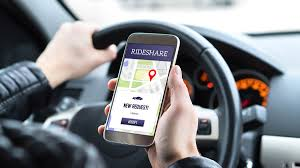

### Part 0.1: Context for Attributes


Here is a description of each column in the raw downloaded dataset:
*   id: unique identifier for each column
*   timestamp: unix timestamp (seconds since Jan 1, 1970)
*   hour: hour of the day (0-23)
*   day: day of the week
*   month: month of the year
*   datetime: date of form yyyy-mm-dd hh:mm:ss
*   timezone: unique timezone
*   source: initial location of the ride (general area)
*   destination: final location of the ride (general area)
*   cab_type: uber/lyft
*   product_id: unique id for the type of uber/lyft service
*   name: type of uber or lyft service (e.g. UberXL, LuxBlackXL)
*   price: price of ride ($USD)
*   distance: total distance of the ride
*   latitude and longitude
*   weather columns: temperature (°F), short summary (e.g. overcast, rainy), long summary (e.g. mostly cloudly throughout the day), precipIntensity (amount of rain), precipProbability ([0-1]), humidity ([0.38-0.96]), windSpeed, windGust, visibility, temperatureHigh, temperatureLow, icon (description of weather emoji), dewPoint, pressure, cloudCover, uvIndex, ozone, sunriseTime, sunsetTime, etc.








## Part 1: Imports and Loading the Dataset

In [1]:
!pip install pyspark
!pip install pyspark --user

In [2]:
# Imports
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
from folium.plugins import HeatMap
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset

In [3]:
!pip install pandasql
from pandasql import sqldf

We utilize drive to load our CSV dataset, downloaded from Kaggle.

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Get file path of the csv file
file_path = '/content/drive/MyDrive/Colab Notebooks/rideshare_kaggle.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

## Part 2: Preprocessing, Feature Engineering, and Initial Data Inspection

### Part 2.1: Dimensions and Random Subset

First, we inspect the size of our initial data frame.

In [6]:
# Get the dimensions of the DataFrame (number of rows and columns)
dimensions = df.shape
dimensions

(693071, 57)

We see that we have about 693,000 rows with 57 features. To clean the data, we first remove rows with NAs. Then, in order to make our data analyses faster to compute, we take a random subset of the data to work with.

In [7]:
# Drop rows with NA values
df_cleaned = df.dropna()

# Check dimensions after dropping NA values
print("Dimensions after dropping NAs:", df_cleaned.shape)

Dimensions after dropping NAs: (637976, 57)


In [8]:
# Get a random subset of 55,000 rows

rideshare_df = df_cleaned.sample(n=55000, random_state=42)

# Check dimensions of the subset
print("Dimensions of the subset:", rideshare_df.shape)

Dimensions of the subset: (55000, 57)


After taking a subset of the data, we verify that the dimensions of our new dataset are correct.

### Part 2.2: Inspect the Dataset and Check for Imbalance

#### 2.2.1: Inspect the Data

We inspect a few rows of the dataframe to see what it looks like.

In [9]:
rideshare_df.head(10)

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
526491,bf7b7290-b915-499a-bd83-c3c1dddbdaae,1.544856e+09,6,15,12,2018-12-15 06:35:07,America/New_York,Financial District,Fenway,Lyft,...,0.0074,1544893200,39.54,1544929200,54.47,1544896800,36.46,1544929200,53.80,1544896800
506474,367c6680-a35b-42a4-bd78-f3e08b730b9c,1.545005e+09,0,17,12,2018-12-17 00:00:12,America/New_York,West End,Boston University,Uber,...,0.1254,1544979600,38.94,1544954400,43.73,1544990400,33.99,1545019200,38.39,1544986800
139551,fcae1e34-fec4-44a6-aee1-dbf6bb20f58a,1.543839e+09,12,3,12,2018-12-03 12:17:59,America/New_York,South Station,Theatre District,Lyft,...,0.0004,1543852800,42.91,1543896000,57.04,1543852800,39.59,1543896000,56.37,1543852800
235222,0c586368-d817-479f-b051-19bbf7b54161,1.543290e+09,3,27,11,2018-11-27 03:45:22,America/New_York,Financial District,Haymarket Square,Uber,...,0.1225,1543251600,40.45,1543233600,46.49,1543255200,37.17,1543291200,43.84,1543244400
140436,42e8d2a6-98ea-47b3-8c98-d339b6d046d2,1.543482e+09,9,29,11,2018-11-29 09:03:03,America/New_York,North End,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
62314,826f20db-ebf4-450d-beb5-cbb243d4f023,1.543661e+09,10,1,12,2018-12-01 10:38:04,America/New_York,Financial District,Boston University,Uber,...,0.0000,1543683600,31.26,1543658400,44.80,1543690800,27.76,1543658400,44.13,1543690800
192444,fdf8429f-2d48-46d6-b20a-394fc8950512,1.544896e+09,17,15,12,2018-12-15 17:40:06,America/New_York,Financial District,Northeastern University,Lyft,...,0.0077,1544893200,39.80,1544929200,54.29,1544896800,36.78,1544929200,53.62,1544896800
309129,12b6766f-e343-4dcb-b05a-5ce805e9ac09,1.544769e+09,6,14,12,2018-12-14 06:30:10,America/New_York,North Station,Haymarket Square,Lyft,...,0.0000,1544806800,27.27,1544781600,46.51,1544814000,24.61,1544785200,43.74,1544817600
33575,5d013d3e-2c2a-471f-a7c2-3efc54b6e419,1.543323e+09,12,27,11,2018-11-27 12:54:22,America/New_York,Boston University,Theatre District,Uber,...,0.1420,1543338000,35.98,1543377600,46.89,1543320000,31.86,1543377600,43.85,1543320000
87489,68444be4-9d36-42ce-9a57-77867af8cf3a,1.544743e+09,23,13,12,2018-12-13 23:15:03,America/New_York,West End,Boston University,Uber,...,0.0001,1544716800,17.91,1544688000,33.81,1544731200,13.47,1544688000,32.82,1544734800


#### 2.2.2 Change Variables to Categorical

This step helps with checking for imbalance in the dataset, which we will address when splitting the data into train and test datasets later on.

In [10]:
# Convert 'cab_type', 'source', 'destination', 'name', and 'short_summary' to categorical data type
rideshare_df['cab_type'] = rideshare_df['cab_type'].astype('category')
rideshare_df['source'] = rideshare_df['source'].astype('category')
rideshare_df['source'] = rideshare_df['source'].astype('category')
rideshare_df['destination'] = rideshare_df['destination'].astype('category')
rideshare_df['name'] = rideshare_df['name'].astype('category')
rideshare_df['short_summary'] = rideshare_df['short_summary'].astype('category')

#### 2.2.3 Check for Imbalance

We can now check if any columns with categorical data have any very imbalanced data. Having this information now will be useful later on for when we do machine learning.

In [11]:
category_columns = ['cab_type', 'source', 'destination', 'name', 'short_summary']

for col in category_columns:
    print(rideshare_df[col].value_counts())

cab_type
Uber    28620
Lyft    26380
Name: count, dtype: int64
source
Haymarket Square           4722
Fenway                     4670
Financial District         4612
Boston University          4610
Beacon Hill                4600
Northeastern University    4591
North End                  4586
West End                   4571
South Station              4554
Back Bay                   4535
North Station              4502
Theatre District           4447
Name: count, dtype: int64
destination
Back Bay                   4749
Beacon Hill                4684
Financial District         4671
West End                   4642
Northeastern University    4634
Boston University          4613
Haymarket Square           4575
North End                  4529
Fenway                     4525
North Station              4502
Theatre District           4485
South Station              4391
Name: count, dtype: int64
name
UberPool        4808
UberX           4794
Black           4775
UberXL          4758
WAV      

All the categories across these columns seem to be relatively balanced. The only variable that seems to be somewhat imbalanced is short_summary, with some values like drizzle being less common than overcast, but this makes sense beause it is proportional to the different types of weather commonly seen.

<ipython-input-12-b2f971c96ffb>:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='firebrick', edgecolor='firebrick', alpha=0.8),
<ipython-input-12-b2f971c96ffb>:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0,0),1,1, color='royalblue', edgecolor='royalblue', alpha=0.8)


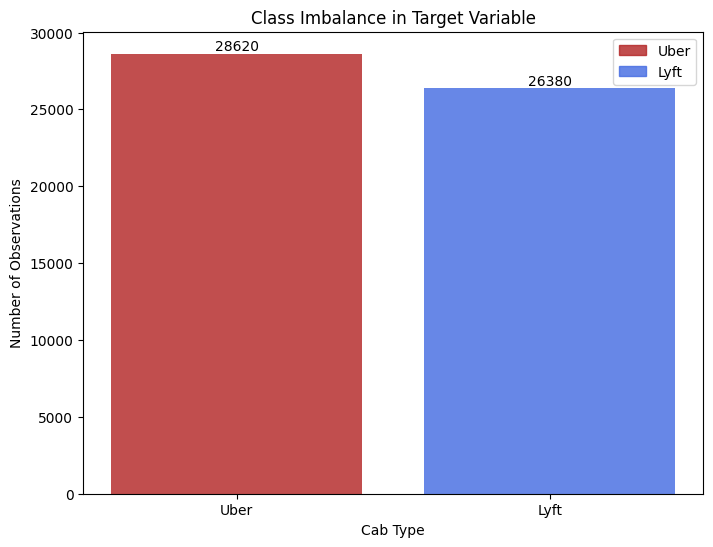

In [12]:
# TODO: Plot target variable
# count num observations per class
class_counts = rideshare_df['cab_type'].value_counts()

# make bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=['firebrick', 'royalblue'], alpha=0.8)

# labels & title
plt.title('Class Imbalance in Target Variable')
plt.xlabel('Cab Type')
plt.ylabel('Number of Observations')
plt.xticks(class_counts.index, ['Uber', 'Lyft'])


# text for each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

# legend
legend_handles = [
    plt.Rectangle((0,0),1,1, color='firebrick', edgecolor='firebrick', alpha=0.8),
    plt.Rectangle((0,0),1,1, color='royalblue', edgecolor='royalblue', alpha=0.8)
]
plt.legend(legend_handles, ['Uber', 'Lyft'])

plt.show()

From the bar chart above, we see that there are slightly more Uber rides than Lyft rides, causing a slight imbalance in the data. To address this, we will use "stratify" to select data such that there are even numbers of both types. We do this step later on when we split our data into train/validation/test data sets. See section 4.

### Part 2.3: Make New Columns

We now aim to create new features for our dataset using the given features to extract any new possible information.

#### Part 2.3.1: Make Year Column

Since we already have a day and month column, we use the datetime column to extract the year and create a new column for that.

In [13]:
# Convert 'datetime_column' to pandas datetime type
rideshare_df['datetime'] = pd.to_datetime(rideshare_df['datetime'])

# Extract the year
rideshare_df['year'] = rideshare_df['datetime'].dt.year

rideshare_df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,year
526491,bf7b7290-b915-499a-bd83-c3c1dddbdaae,1.544856e+09,6,15,12,2018-12-15 06:35:07,America/New_York,Financial District,Fenway,Lyft,...,1544893200,39.54,1544929200,54.47,1544896800,36.46,1544929200,53.80,1544896800,2018
506474,367c6680-a35b-42a4-bd78-f3e08b730b9c,1.545005e+09,0,17,12,2018-12-17 00:00:12,America/New_York,West End,Boston University,Uber,...,1544979600,38.94,1544954400,43.73,1544990400,33.99,1545019200,38.39,1544986800,2018
139551,fcae1e34-fec4-44a6-aee1-dbf6bb20f58a,1.543839e+09,12,3,12,2018-12-03 12:17:59,America/New_York,South Station,Theatre District,Lyft,...,1543852800,42.91,1543896000,57.04,1543852800,39.59,1543896000,56.37,1543852800,2018
235222,0c586368-d817-479f-b051-19bbf7b54161,1.543290e+09,3,27,11,2018-11-27 03:45:22,America/New_York,Financial District,Haymarket Square,Uber,...,1543251600,40.45,1543233600,46.49,1543255200,37.17,1543291200,43.84,1543244400,2018
140436,42e8d2a6-98ea-47b3-8c98-d339b6d046d2,1.543482e+09,9,29,11,2018-11-29 09:03:03,America/New_York,North End,North Station,Lyft,...,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800,2018


#### Part 2.3.2: Make DayLength Column

For any given day, we are interested in how long the sun was up. This way we can condense two columns (sunriseTime and sunsetTime) into one in order to reduce dimensionality.

In [14]:
rideshare_df['lengthOfDay'] = rideshare_df['sunsetTime'] - rideshare_df['sunriseTime']

Confirming that our new column was added (time unit is seconds):

In [15]:
column_names = rideshare_df.columns.tolist()
column_names

['id',
 'timestamp',
 'hour',
 'day',
 'month',
 'datetime',
 'timezone',
 'source',
 'destination',
 'cab_type',
 'product_id',
 'name',
 'price',
 'distance',
 'surge_multiplier',
 'latitude',
 'longitude',
 'temperature',
 'apparentTemperature',
 'short_summary',
 'long_summary',
 'precipIntensity',
 'precipProbability',
 'humidity',
 'windSpeed',
 'windGust',
 'windGustTime',
 'visibility',
 'temperatureHigh',
 'temperatureHighTime',
 'temperatureLow',
 'temperatureLowTime',
 'apparentTemperatureHigh',
 'apparentTemperatureHighTime',
 'apparentTemperatureLow',
 'apparentTemperatureLowTime',
 'icon',
 'dewPoint',
 'pressure',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility.1',
 'ozone',
 'sunriseTime',
 'sunsetTime',
 'moonPhase',
 'precipIntensityMax',
 'uvIndexTime',
 'temperatureMin',
 'temperatureMinTime',
 'temperatureMax',
 'temperatureMaxTime',
 'apparentTemperatureMin',
 'apparentTemperatureMinTime',
 'apparentTemperatureMax',
 'apparentTemperatureMaxTime',
 'year',


### Part 2.4 REGEX for Data Type Conversions and One-Hot Encoding

We make the source, destination, name (ride type, such as Black SUV, UberPool, etc.), short_summary (weather information), icon (weather emoji), and cab_type (Uber/Lyft) columns categorical. For the correlation matrix, we want numerical data, so we use a One-Hot encoding for the Uber/Lyft type.

We create a copy of rideshare_df in order to make future analyses using the categorical data easier.

In [16]:
rideshare_df_categorical = rideshare_df.copy()

In [17]:
# Binary one-hot encoding
# One-hot encoding for Uber and Lyft
# We obtain one column indicating whether or not a cab was Uber (1) or Lyft (0)
rideshare_df = pd.get_dummies(rideshare_df, columns=['cab_type'], prefix='cab_type', drop_first=True)

In [18]:
# One hot encoding outputted a bool datatype, but we convert to 0/1
rideshare_df['cab_type_Uber'] = rideshare_df['cab_type_Uber'].astype('int32')

In [19]:
# One-hot encoding for nominal variables
# This creates several new columns
rideshare_df = pd.get_dummies(rideshare_df, columns=['source', 'destination', 'name', 'short_summary'], drop_first=True)

In [20]:
# Define the regex pattern to match column names
pattern = re.compile(r'^(source|destination|name|short_summary)_.*$')

# List of columns to convert to int32
columns_to_convert = [col for col in rideshare_df.columns if pattern.match(col)]

# Convert each column to int32
for col in columns_to_convert:
    rideshare_df[col] = rideshare_df[col].astype('int32')

In [21]:
# Confirming new columns added correctly
rideshare_df.shape

(55000, 96)

### Part 2.5: Remove Unnecessary "Object"-type Variables

Since our future analyses will rely on only having numerical data, we remove other columns that are not categorical but still non-numerical.

In [22]:
rideshare_df.drop(['id', 'timezone', 'product_id', 'long_summary', 'icon'], axis=1, inplace=True)

In [23]:
print(rideshare_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 55000 entries, 526491 to 391923
Data columns (total 91 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   timestamp                            55000 non-null  float64       
 1   hour                                 55000 non-null  int64         
 2   day                                  55000 non-null  int64         
 3   month                                55000 non-null  int64         
 4   datetime                             55000 non-null  datetime64[ns]
 5   price                                55000 non-null  float64       
 6   distance                             55000 non-null  float64       
 7   surge_multiplier                     55000 non-null  float64       
 8   latitude                             55000 non-null  float64       
 9   longitude                            55000 non-null  float64       
 10  temperatu

### Part 2.5: Correlation Heatmap

We create a correlation heatmap of all of the variables so that we can remove the ones that are very positively or very negatively correlated. The output is plotted below.

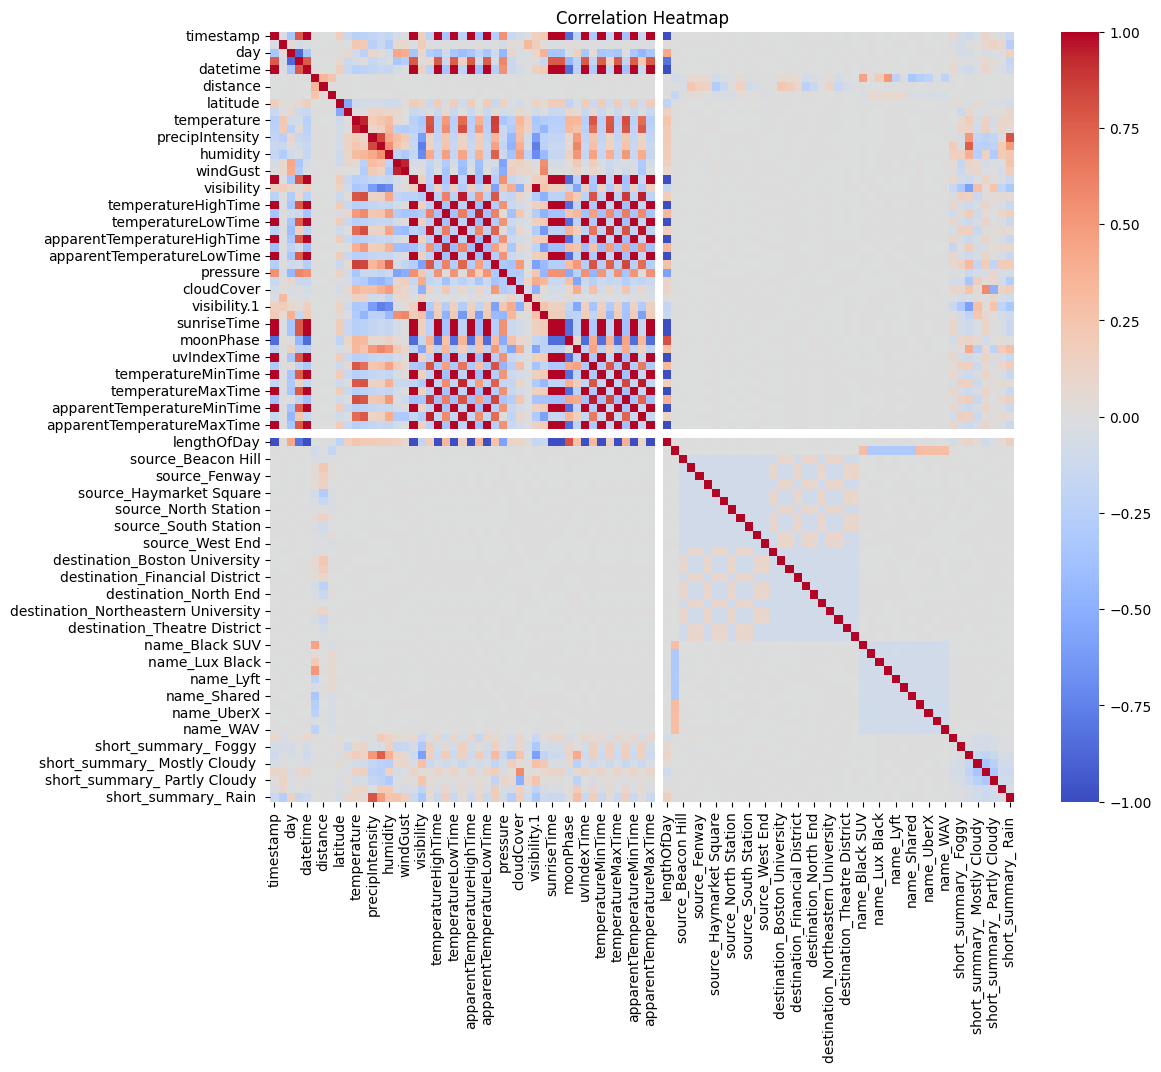

In [24]:
# Calculate correlation matrix
corr_matrix = rideshare_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

We can see from above that there are many variables, but all of the correlations are in the upper-left, so we now only the consider the first 30 variables.

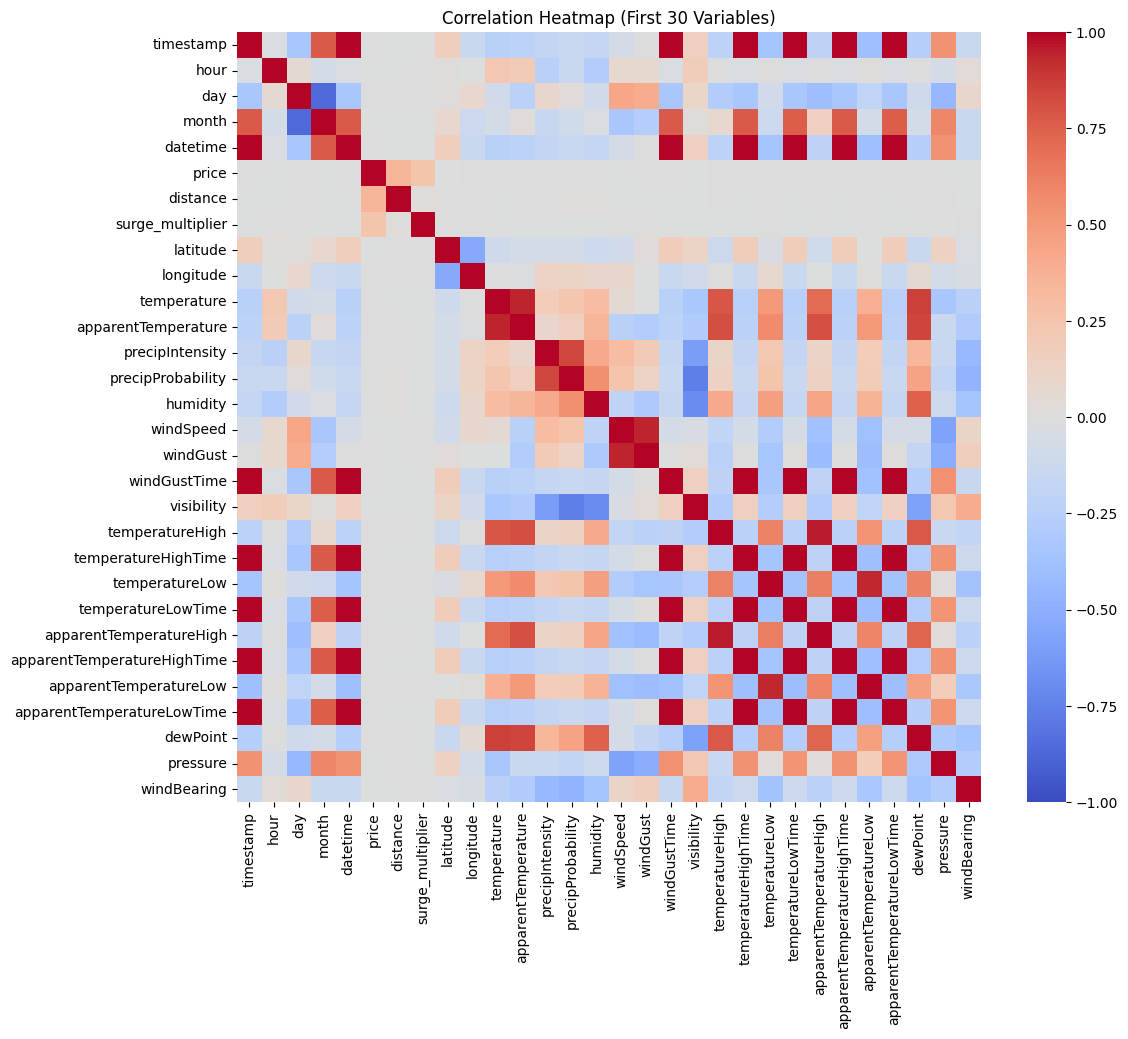

In [25]:
# Calculate correlation matrix with only the first 60 variables
corr_matrix = rideshare_df.iloc[:, :30].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap (First 30 Variables)')
plt.show()

### Part 2.6: Removing Correlated Variables

From the correlation heatmap above, we can see that certain variables are highly correlated (very red/very blue squares). These tend to be redundant information and removing these extra variables can help us manually reduce dimensions. We will continue with dimensionality reduction later on, but for now, we will just remove highly correlated variables.

In [26]:
rideshare_df.drop(['apparentTemperatureMinTime', 'apparentTemperatureMaxTime', 'sunriseTime', 'sunsetTime', 'apparentTemperatureLowTime', 'apparentTemperatureHighTime', 'moonPhase', 'windGustTime', 'windGust', 'precipProbability', 'apparentTemperature', 'dewPoint', 'datetime', 'uvIndexTime', 'visibility.1', 'surge_multiplier'], axis=1, inplace=True)

We confirm that we remove the right number of columns. We see that we have 75 columns after cleaning the unnecessary columns.

In [27]:
rideshare_df.shape

(55000, 75)

### Part 2.7: Remove Outliers

We want to remove outliers in the data. First, we look at the summary statistics to see at a glance if the min and max values are outside the range that we would expect. We then manually remove rows with outliers. We only focus on price and distance since those are the columns where removing outliers makes the most sense.

In [28]:
rideshare_df.describe()

,timestamp,hour,day,month,price,distance,latitude,longitude,temperature,precipIntensity,...,name_UberXL,name_WAV,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain
count,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.00000,55000.000000,55000.000000,55000.000000
mean,1.544042e+09,11.656109,17.770855,11.586145,16.549179,2.192818,42.338056,-71.066109,39.626492,0.008993,...,0.086509,0.086473,0.010636,0.013018,0.079127,0.210673,0.31480,0.183618,0.026982,0.034800
std,6.876669e+05,6.968292,10.008221,0.492528,9.336526,1.135126,0.048003,0.020322,6.703281,0.027049,...,0.281117,0.281063,0.102584,0.113353,0.269940,0.407790,0.46444,0.387176,0.162032,0.183275
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.020000,42.214800,-71.105400,18.910000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.543444e+09,6.000000,13.000000,11.000000,9.000000,1.280000,42.350300,-71.081000,36.450000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.543736e+09,12.000000,17.000000,12.000000,13.500000,2.170000,42.351900,-71.063100,40.550000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.544823e+09,18.000000,28.000000,12.000000,22.500000,2.930000,42.364700,-71.054200,43.610000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
max,1.545161e+09,23.000000,30.000000,12.000000,92.000000,7.860000,42.366100,-71.033000,57.220000,0.144700,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [29]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5 * IQR
    outliers = column[(column < Q1 - threshold) | (column > Q3 + threshold)]
    return outliers

# Detect outliers for each column
outlier_indices = set()
for col_name in ['price', 'distance']:
    outliers = detect_outliers(rideshare_df[col_name])
    outlier_indices.update(outliers.index)

In [30]:
rideshare_df = rideshare_df.drop(outlier_indices)

In [31]:
rideshare_df.shape

(53985, 75)

We see that we have gone down from 55,000 to just under 54,000 rows after cleaning for outliers.

## Part 3: Exploratory Data Analysis (EDA)

### Part 3.1: Summary Statistics

First, we inspect the data types of the different variables of our dataset.

In [32]:
rideshare_df.dtypes

timestamp                           float64
hour                                  int64
day                                   int64
month                                 int64
price                               float64
                                     ...   
short_summary_ Mostly Cloudy          int32
short_summary_ Overcast               int32
short_summary_ Partly Cloudy          int32
short_summary_ Possible Drizzle       int32
short_summary_ Rain                   int32
Length: 75, dtype: object

In [33]:
# Get some summary statistics
rideshare_df.describe()

,timestamp,hour,day,month,price,distance,latitude,longitude,temperature,precipIntensity,...,name_UberXL,name_WAV,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain
count,5.398500e+04,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,...,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000,53985.000000
mean,1.544043e+09,11.655997,17.771177,11.586200,16.188827,2.136660,42.338049,-71.066117,39.620073,0.009004,...,0.086283,0.086709,0.010707,0.013078,0.078966,0.210410,0.314458,0.184033,0.027008,0.034954
std,6.875807e+05,6.971075,10.006574,0.492518,8.745071,1.044932,0.048003,0.020325,6.708280,0.027083,...,0.280784,0.281411,0.102919,0.113609,0.269689,0.407604,0.464304,0.387514,0.162107,0.183665
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.020000,42.214800,-71.105400,18.910000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.543444e+09,6.000000,13.000000,11.000000,9.000000,1.260000,42.350300,-71.081000,36.450000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.543736e+09,12.000000,17.000000,12.000000,13.500000,2.140000,42.351900,-71.063100,40.550000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.544823e+09,18.000000,28.000000,12.000000,22.500000,2.860000,42.364700,-71.054200,43.610000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.545161e+09,23.000000,30.000000,12.000000,42.500000,5.400000,42.366100,-71.033000,57.220000,0.144700,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see the min, max, mean, median, quartiles, and standard deviations of the various features from the output above. We complete analyses on this statistics below.

### Part 3.2: Uber versus Lyft Statistics

We first analyze the statistics for the subset of the data that is Uber and the subset that is Lyft to see any similarities or differences.

In [34]:
# Split the data based on cab_type
uber_data = rideshare_df[rideshare_df['cab_type_Uber'] == 1]
lyft_data = rideshare_df[rideshare_df['cab_type_Uber'] == 0]

# EDA
# Compare summary statistics for numerical features
print("Summary statistics for Uber:")
uber_data.describe()

Summary statistics for Uber:


,timestamp,hour,day,month,price,distance,latitude,longitude,temperature,precipIntensity,...,name_UberXL,name_WAV,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain
count,2.802100e+04,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.00000,28021.000000,28021.000000,28021.000000,...,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000,28021.000000
mean,1.544045e+09,11.647836,17.831591,11.585311,15.503533,2.113276,42.33749,-71.065881,39.618854,0.008985,...,0.166232,0.167053,0.010956,0.012705,0.077192,0.208701,0.316834,0.185754,0.027586,0.035509
std,6.893403e+05,6.985543,9.974597,0.492677,8.212266,1.032986,0.04862,0.020335,6.690573,0.027101,...,0.372296,0.373030,0.104098,0.111999,0.266901,0.406387,0.465250,0.388915,0.163788,0.185066
min,1.543204e+09,0.000000,1.000000,11.000000,4.500000,0.020000,42.21480,-71.105400,18.910000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.543445e+09,6.000000,13.000000,11.000000,9.000000,1.280000,42.35030,-71.081000,36.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.543737e+09,12.000000,17.000000,12.000000,12.500000,2.140000,42.35190,-71.063100,40.490000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.544828e+09,18.000000,28.000000,12.000000,20.500000,2.840000,42.36470,-71.054200,43.610000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.545161e+09,23.000000,30.000000,12.000000,42.500000,5.160000,42.36610,-71.033000,57.220000,0.144700,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
print("Summary statistics for Lyft:")
lyft_data.describe()

Summary statistics for Lyft:


,timestamp,hour,day,month,price,distance,latitude,longitude,temperature,precipIntensity,...,name_UberXL,name_WAV,short_summary_ Drizzle,short_summary_ Foggy,short_summary_ Light Rain,short_summary_ Mostly Cloudy,short_summary_ Overcast,short_summary_ Partly Cloudy,short_summary_ Possible Drizzle,short_summary_ Rain
count,2.596400e+04,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,...,25964.0,25964.0,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000,25964.000000
mean,1.544039e+09,11.664805,17.705978,11.587159,16.928414,2.161896,42.338652,-71.066372,39.621388,0.009025,...,0.0,0.0,0.010438,0.013480,0.080881,0.212255,0.311893,0.182175,0.026383,0.034355
std,6.856763e+05,6.955551,10.040755,0.492354,9.229090,1.057113,0.047322,0.020312,6.727466,0.027064,...,0.0,0.0,0.101632,0.115321,0.272658,0.408913,0.463275,0.385996,0.160274,0.182144
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.390000,42.214800,-71.105400,18.910000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.543443e+09,6.000000,13.000000,11.000000,9.000000,1.260000,42.350300,-71.081000,36.270000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.543735e+09,12.000000,17.000000,12.000000,16.500000,2.130000,42.351900,-71.063100,40.610000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.544819e+09,18.000000,28.000000,12.000000,22.500000,2.960000,42.364700,-71.054200,43.580000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.545161e+09,23.000000,30.000000,12.000000,42.500000,5.400000,42.366100,-71.033000,57.220000,0.144700,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that both Uber and Lyft have similar mean distances (2.19) and that Uber has a larger max distance (7.5 versus 6.1). The average price for Lyft is higher at \$17.42, whereas Uber has a mean of just \$15.75.

We wanted to check the distribution of the different categories in the `name` column between both Uber and Lyft dataframes. We can see there is a roughly even count across all 6 `name` categories for Uber, and all 6 for Lyft (the categories are mutually exclusive and non-overlapping between Uber and Lyft).

In [36]:
# For Uber
print("Uber data:")
name_columns = [col for col in uber_data.columns if col.startswith('name_')]
for col in name_columns:
    total = uber_data[col].sum()
    print(f"Total sum for column {col}: {total}")

print("----------------")

# For Lyft
print("Lyft data:")
name_columns = [col for col in lyft_data.columns if col.startswith('name_')]
for col in name_columns:
    total = lyft_data[col].sum()
    print(f"Total sum for column {col}: {total}")

Uber data:
Total sum for column name_Black SUV: 4578
Total sum for column name_Lux: 0
Total sum for column name_Lux Black: 0
Total sum for column name_Lux Black XL: 0
Total sum for column name_Lyft: 0
Total sum for column name_Lyft XL: 0
Total sum for column name_Shared: 0
Total sum for column name_UberPool: 4722
Total sum for column name_UberX: 4692
Total sum for column name_UberXL: 4658
Total sum for column name_WAV: 4681
----------------
Lyft data:
Total sum for column name_Black SUV: 0
Total sum for column name_Lux: 4342
Total sum for column name_Lux Black: 4378
Total sum for column name_Lux Black XL: 4117
Total sum for column name_Lyft: 4295
Total sum for column name_Lyft XL: 4414
Total sum for column name_Shared: 4418
Total sum for column name_UberPool: 0
Total sum for column name_UberX: 0
Total sum for column name_UberXL: 0
Total sum for column name_WAV: 0


Now, we analyze the differences in hour, price, and distance through the following visualizations:

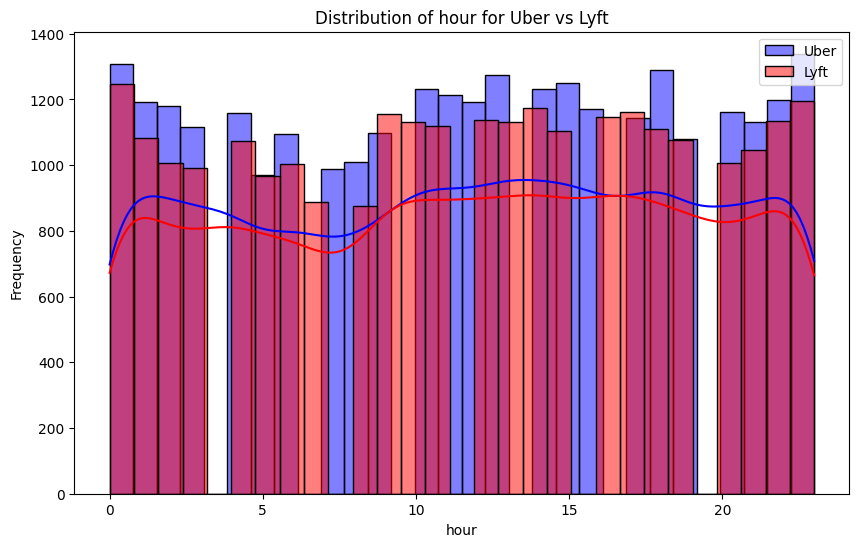

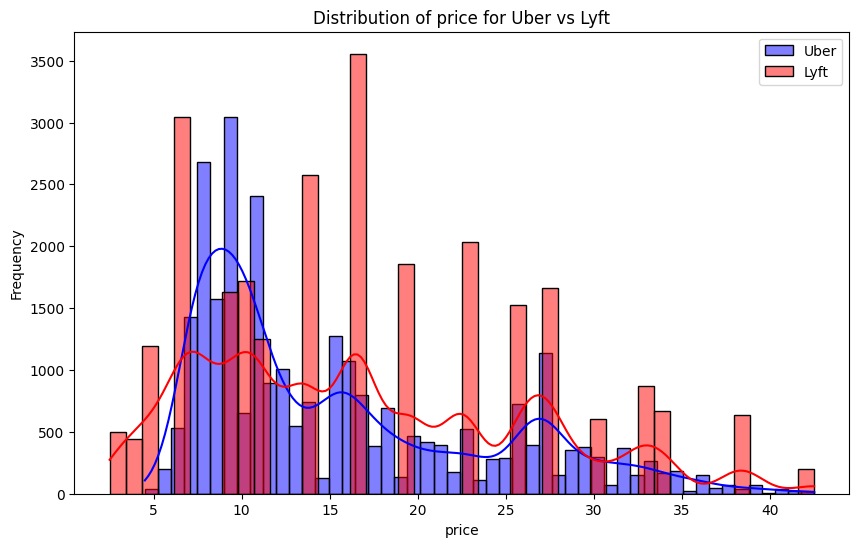

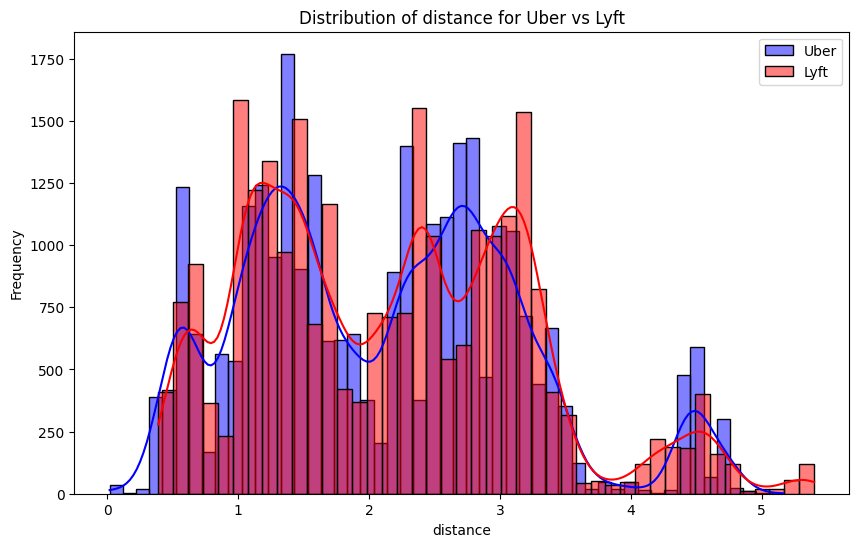

In [37]:
# Compare distributions of numerical features visually
numerical_features = ['hour', 'price', 'distance']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(uber_data[feature], color='blue', alpha=0.5, label='Uber', kde=True)
    sns.histplot(lyft_data[feature], color='red', alpha=0.5, label='Lyft', kde=True)
    plt.title(f'Distribution of {feature} for Uber vs Lyft')
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


From the above outputs, we can see that overall, the hour, price, and distance distributions are similar between both Uber and Lyft. Lyft tends to have higher pricing, and Uber tends to have higher frequencies for some of the longer distance rides. In the hour histogram, we see they follow a very similar pattern, just that Uber has higher frequencies.

### Part 3.3: General Data Visualizations

#### Part 3.3.1: Histogram of Rides per Hour

First, we are interested in the number of rides per hour. We build a histogram to visualize these frequencies as follows:

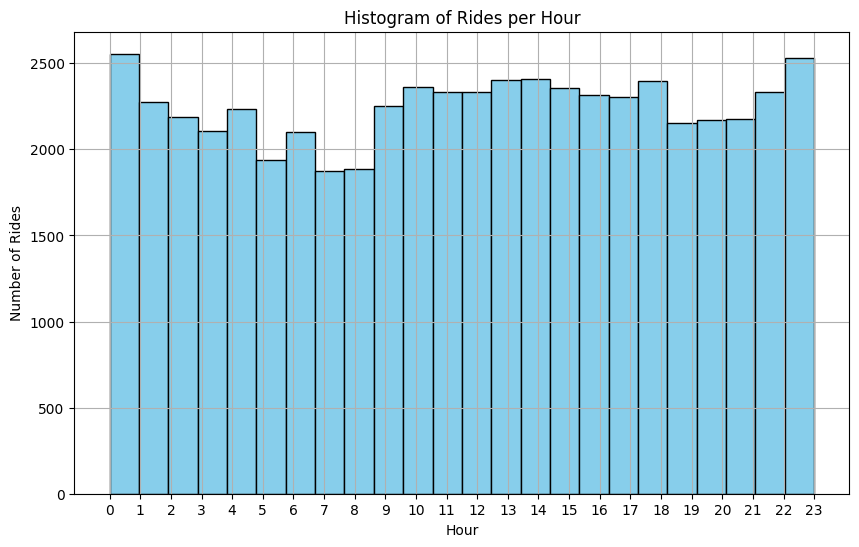

In [38]:
# Histogram of rides per hour
plt.figure(figsize=(10, 6))
plt.hist(rideshare_df['hour'], bins=24, color='skyblue', edgecolor='black')
plt.title('Histogram of Rides per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.xticks(range(24))
plt.grid(True)
plt.show()

Based on our histogram of the number of rides per hour, we see that rideshare demand peaks at midnight hours and hours around noon-afternoon, whereas it dips at around 5 am in the morning and 7 pm in the evening. This peak in the afternoon hours might be for people finishing up work or school. Also, demand might be high at midnight since people might find public transportation to be less safe during those times.

#### Part 3.3.2: Heatmap of Rides

We now make a heatmap of the rides based on their longitude and latitude. This is important to do since we can identify which areas have higher traffic and higher frequency of rides. This analysis might be useful later down the line when we check the correlation with area and price. The map visualization best helps us identify the different areas easily. Folium helps us use a clean map visualization. Based on our ouput below, rather than an even distribution throughout Boston, we see certain areas with concentrated frequencies. The most common areas are Boston North Station and North End. Also note that the latitude and longitude are based on the source areas, which is categorical, leading to less variance. We will verify our findings later on by checking the price statistics for each location.

In [39]:
# Base map centered around the mean latitude & longitude
base_map = folium.Map(location=[rideshare_df['latitude'].mean(), rideshare_df['longitude'].mean()], zoom_start=10)

# Extract latitude & longitude columns
locations = rideshare_df[['latitude', 'longitude']]

# Convert to list of lists format
location_list = locations.values.tolist()

# Create a heatmap layer
heatmap_layer = HeatMap(location_list)

# Add heatmap layer to the base map
base_map.add_child(heatmap_layer)

base_map

#### Part 3.3.3: Scatterplot of Temperature versus Price

We now aim to see what impact temperature has on the price, both for Uber and for Lyft. We use a scatterplot to see each ride as a point.

In [40]:
uber_data_categorical = rideshare_df_categorical[rideshare_df_categorical['cab_type'] == 'Uber']
lyft_data_categorical = rideshare_df_categorical[rideshare_df_categorical['cab_type'] == 'Lyft']

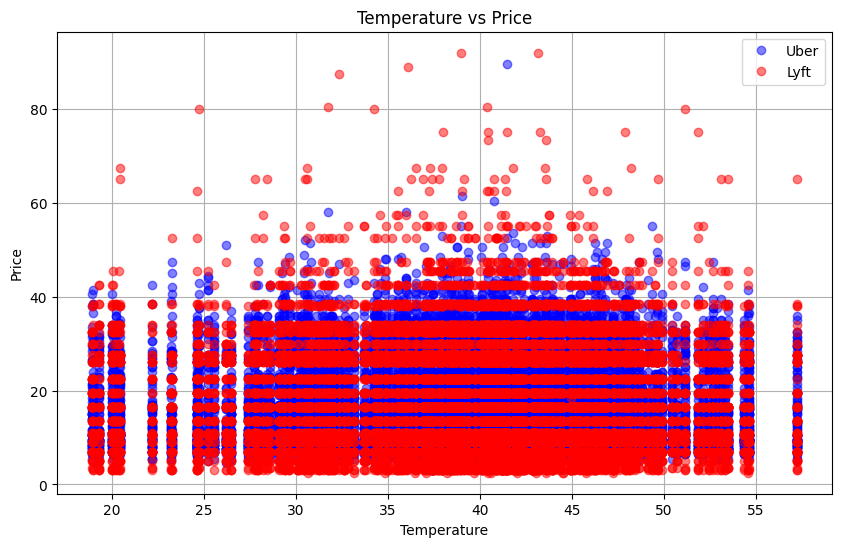

In [41]:
# Plot temperature versus price
plt.figure(figsize=(10, 6))
plt.plot(uber_data_categorical['temperature'], uber_data_categorical['price'], 'bo', label='Uber', alpha=0.5)
plt.plot(lyft_data_categorical['temperature'], lyft_data_categorical['price'], 'ro', label='Lyft', alpha=0.5)
plt.title('Temperature vs Price')
plt.xlabel('Temperature')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Based on the temperature versus price scatterplot seen above, where blue dots represent Uber rides and red represent Lyft rides, we see a bell curve type of trend, with peak prices around the 35 to 40 degrees range. We believe this might indicate that in the lower temperature ranges, such as 20 to 25 degrees, there might have been lower demand since people might have been less likely and less willing to go outside. This might have caused the rideshare companies to lower their price due to lower demand. However in higher demand times in the middle temperature range, rideshare companies probably had to increase prices. This would help mitigate the high demand by creating a "scarcity" effect. Both curves (Uber and Lyft) seem to be rather similar in shape, but Lyft tends to have higher prices overall.

#### Part 3.3.4: Box-and-Whisker plots of Ride Type versus Price


For our categorical variables, box-and-whisker plots are great for seeing the median and spread for each category separately. We first do this for Ride type:

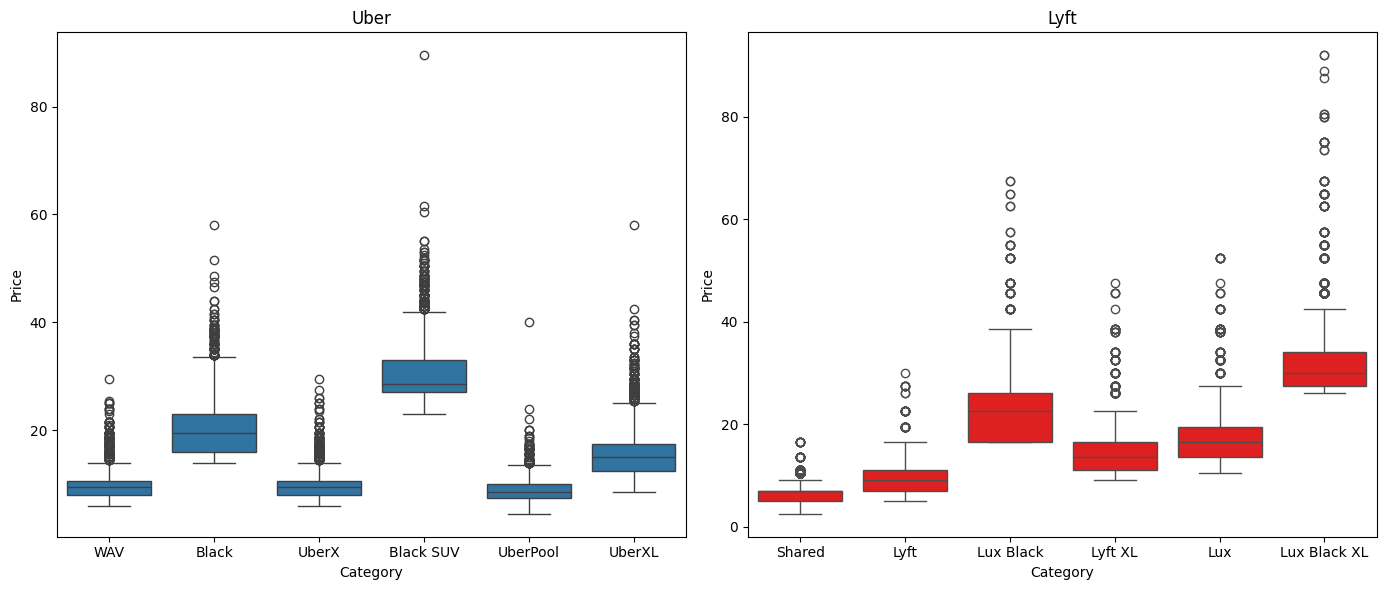

In [42]:
# Set the option to suppress the warning
pd.options.mode.chained_assignment = None


# Create a new column 'name1' and copy values (Uber)
uber_data_categorical['name1'] = ''
for index, row in uber_data_categorical.iterrows():
    uber_data_categorical.at[index, 'name1'] = row['name']

# Create a new column 'name1' and copy values (Lyft)
lyft_data_categorical['name1'] = ''
for index, row in lyft_data_categorical.iterrows():
    lyft_data_categorical.at[index, 'name1'] = row['name']

# Make two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot boxplots for Uber
sns.boxplot(x='name1', y='price', data=uber_data_categorical, ax=axes[0])
axes[0].set_title('Uber')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Price')

# Plot boxplots for Lyft
sns.boxplot(x='name1', y='price', data=lyft_data_categorical, ax=axes[1], color='red')
axes[1].set_title('Lyft')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

Based on the boxplots above, with blue for Uber and red for Lyft, we see that the median prices across all 6 of the categories in Uber and all 6 categories in Lyft are varied. For Uber, the Black SUV rides are the most expensive, whereas for Lyft, the Lux Black XL rides are the most exponesive. Uber's UberPool and Lyft's Shared services tend to be the chepeast, which makes sense since that is a common way that ridesharing companies offer cheaper deals: sharing a ride with other customers.

#### Part 3.3.5: Bar chart of Uber/Lyft Proportions per Area

We plot a bar chart of the proportion of rides that are Uber or Lyft for each of the areas in Boston. By using a barchart, we can easily see which (Uber or Lyft) has a higher frequency in that area.

In [43]:
# Frequencies of Uber & Lyft rides per location
uber_frequencies = uber_data_categorical['source'].value_counts()
lyft_frequencies = lyft_data_categorical['source'].value_counts()

# Unique locations
locations = uber_data_categorical['source'].unique()

# Lists of frequencies for each location
uber_freq_list = []
lyft_freq_list = []

# Iterate over each location
for location in locations:
    uber_freq_list.append(uber_frequencies.get(location, 0))
    lyft_freq_list.append(lyft_frequencies.get(location, 0))

# Df for frequencies
frequencies_df = pd.DataFrame({'Location': locations,
                                'Uber Frequency': uber_freq_list,
                                'Lyft Frequency': lyft_freq_list})

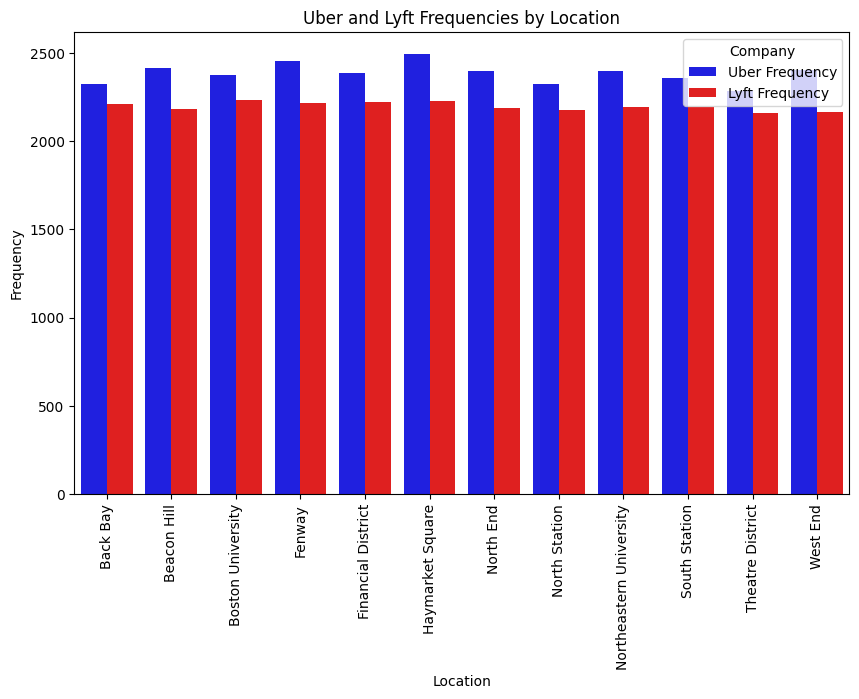

In [44]:
df_long = frequencies_df.melt(id_vars='Location', var_name='Company', value_name='Frequency')
df_long


plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='Frequency', hue='Company', data=df_long, palette={'Uber Frequency': 'blue', 'Lyft Frequency': 'red'})
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Uber and Lyft Frequencies by Location')
plt.legend(title='Company')
plt.show()

Based on the output above, we see that for the most part, both Uber and Lyft service the same areas pretty evenly. Uber has a marginally larger proportion of the rides in all areas. This might be because we have some class imbalance in our dataset.

#### Part 3.3.6: Box-and-Whisker plot of Price versus Area




We made box and whisker plots of price for the different regions to test of the area has an impact on price. This will help us confirm our prediction from when we made the folium map to see if the higher traffic areas have higher prices.

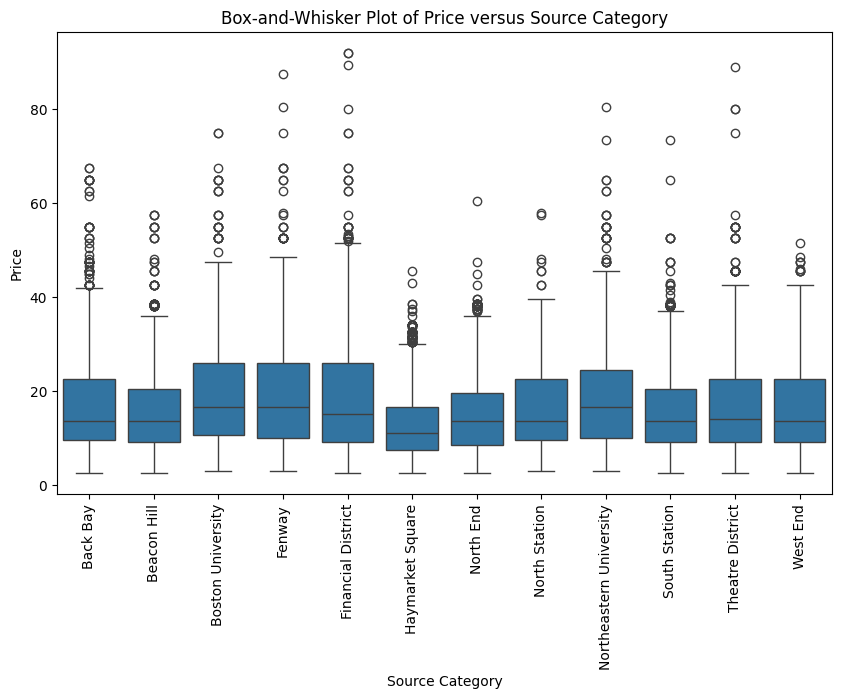

In [45]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the boxplot with rotated x-axis labels
sns.boxplot(x='source', y='price', data=rideshare_df_categorical)
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees

# Set the title and labels
plt.title('Box-and-Whisker Plot of Price versus Source Category')
plt.xlabel('Source Category')
plt.ylabel('Price')

# Show the plot
plt.show()

We see from the output above that the medians and variance are different for the different areas. For example, Financial District has very small spread compared to the other areas. Certain areas, like North Station and Boston University, have higher medians than the other locations, whereas Beacon Hill, Back Bay, and Financial District have lower median prices.

## Part 4: Create training, testing, and validation data

We want a 70/20/10 split of training/validation/test data, respectively. We do this for both cab_type and price as response variables.

Note that sometimes, such as in the case for regression with parameter grid search, we do not need to tune our parameters based on the performance in the validation data. Therefore, in those cases, we can think of the validation set as another test set to judge the performance of our models on.

### Part 4.1: Create data split for cab_type as response variable

We stratify by cab_type in order to get equal representation across both categories.

In [46]:
seed = 123
X = rideshare_df.drop(columns=['cab_type_Uber'])
y = rideshare_df['cab_type_Uber']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=seed, stratify=y_val, shuffle=True)

In [47]:
print("rideshare_df dimensions:")
print(rideshare_df.shape)
print("X_train dimensions:")
print(X_train.shape)
print("X_val dimensions:")
print(X_val.shape)
print("X_test dimensions:")
print(X_test.shape)

rideshare_df dimensions:
(53985, 75)
X_train dimensions:
(37789, 74)
X_val dimensions:
(10851, 74)
X_test dimensions:
(5345, 74)


#### Part 4.1.1: Testing Class Imbalance in Cab Type

Back in section 2, we mentioned that we want to ensure that we addressed class balance using starify when doing our train test split. stratify=y ensures that both the train and test sets have the same class distribution as the original target variable y. To test this, we found the ratio of Ubers in each data subset: training and testing. We found 0.513 as our proportion of Ubers in the training dataset, and 0.515 in the testing dataset, suggesting that our method to address the class imbalance using stratify was successful.

In [48]:
category_columns = ['cab_type_Uber']

for col in category_columns:
    print(pd.DataFrame(y_train)[col].value_counts())

cab_type_Uber
1    19614
0    18175
Name: count, dtype: int64


In [49]:
category_columns = ['cab_type_Uber']

for col in category_columns:
    print(pd.DataFrame(y_test)[col].value_counts())

cab_type_Uber
1    2774
0    2571
Name: count, dtype: int64


### Part 4.2: Create data split for price as response variable

In [50]:
X_price = rideshare_df.drop(columns=['price'])
y_price = rideshare_df['price']
X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_price, y_price, test_size=0.30, random_state=seed, shuffle=True)
X_val_price, X_test_price, y_val_price, y_test_price = train_test_split(X_val_price, y_val_price, test_size=0.33, random_state=seed, shuffle=True)

In [51]:
print("rideshare_df dimensions:")
print(rideshare_df.shape)
print("X_train_price dimensions:")
print(X_train_price.shape)
print("X_val_price dimensions:")
print(X_val_price.shape)
print("X_test_price dimensions:")
print(X_test_price.shape)

rideshare_df dimensions:
(53985, 75)
X_train_price dimensions:
(37789, 74)
X_val_price dimensions:
(10851, 74)
X_test_price dimensions:
(5345, 74)


### Part 4.3: Scale the data

We now use StandardScaler() to scale our data in preparation for our some of our models, such as the neural network, in which we need to use scaled data to ensure proper performance.

In [52]:
# Scale cab type data
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_price)
X_val_scaled = scaler_X.transform(X_val_price)
X_test_scaled = scaler_X.transform(X_test_price)

# Scale price data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_price_scaled = scaler_X.fit_transform(X_train_price)
X_val_price_scaled = scaler_X.transform(X_val_price)
X_test_price_scaled = scaler_X.transform(X_test_price)

y_train_price_scaled = scaler_y.fit_transform(y_train_price.values.reshape(-1, 1)).flatten()
y_test_price_scaled = scaler_y.transform(y_test_price.values.reshape(-1, 1)).flatten()
y_val_price_scaled = scaler_y.transform(y_val_price.values.reshape(-1, 1)).flatten()

## Part 5: PCA and Clustering

For our first model, we utilize principal component analysis for dimension reduction since our dataset has 74 indicator variables. This step will greatly help the model by finding linear combinations of the indicator variables such that variance is maximized. By using a Proportion of Variance Explained line graph, we select the top few PCAs that explain most of the variance in the data and perform clustering analysis to see if the model is able to discern between Uber and Lyft rides.

Some downsides of this model, however, are that the principal components are not as easily understandable as features since they no longer correspond to specific metrics, but rather linear combinations of many. Further, the model is quite simple, which might lead to difficulties in the model differentiating between Uber and Lyft.

By conducting this model, we can identify if the rideshare companies are different and distinguishable, or if Lyft has improved since its entrance in the market to have an even playing field against its competitor, Uber.

### Part 5.1: PCA for cab_type

We use PCA() to transform the scaled data for the principal component analysis.

In [53]:
# Perform PCA
pca = PCA()
pca.fit_transform(X_train_scaled)

array([[-5.79124788e-01, -3.31052171e+00, -8.59801063e-01, ...,
        -5.25652734e-15,  1.12851476e-16,  3.25341649e-17],
       [-4.57599981e+00, -3.97713629e-02,  1.15017197e+00, ...,
        -6.82034791e-16, -1.46917217e-15, -8.52310407e-17],
       [ 6.18791182e+00, -8.95297788e-01, -1.70488978e-01, ...,
        -9.39351565e-15,  1.62535440e-15,  3.70005308e-16],
       ...,
       [-4.00123385e+00, -9.78800394e-01,  3.41441946e-01, ...,
         1.99137581e-16, -1.88909422e-17, -1.37851477e-17],
       [-4.81238612e-01,  4.84118384e+00, -6.77362534e-01, ...,
         6.89645681e-16,  4.97361329e-16, -8.50578640e-17],
       [-6.10141697e-01, -3.35887001e+00, -3.88845829e-01, ...,
         3.59464108e-16,  1.73906524e-16, -3.72863361e-17]])

We then plot the proportion of variance explained, which is a decreasing line graph. We identify where the elbow exists.

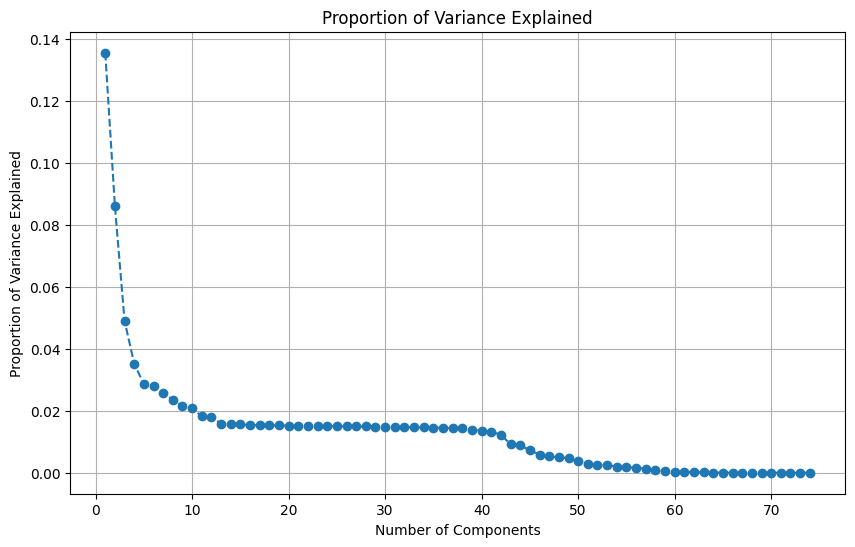

In [54]:
# Plotting the proportion of variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Proportion of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True)
plt.show()

From the elbow curve above, we can see that the variance decreases out at around 5 principal components, so we will only take the first 5 principal components, which will bring the number of indicators down signficantly from 75.

### Part 5.2: k-means Clustering for cab_type

Now, we implement the k-means clustering using the 5 PCs selected above. We specify 2 clusters, since we are interested in seeing if the clusters correspond to Uber and Lyft. We also investigate the centers of the clusters.

In [55]:
seed = 123

# Take only the first 5 PCs
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_train_pca = pd.DataFrame(X_train_pca[:, :5], columns=[f"PC{i+1}" for i in range(5)])

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X_train_pca)

# Add cluster labels to X_train_pca
X_train_pca_clustered = X_train_pca.copy()
X_train_pca_clustered['cluster'] = kmeans.labels_

print("Cluster Centers:")
print(pca.inverse_transform(kmeans.cluster_centers_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
[[-7.18844338e-01  4.95924201e-02  2.73488160e-01 -5.73227543e-01
   6.49693465e-03 -1.46367559e-01  1.12901459e-01  2.59945313e-01
   1.10993563e-01  1.25023713e-01  5.45607418e-02 -8.86266193e-02
   2.55443875e-01 -7.19758694e-01  3.30400200e-01 -7.19630295e-01
   2.30602928e-01  3.36689594e-01 -4.01703438e-01  9.85754290e-02
   1.80722045e-02  4.05730714e-02 -1.59469428e-01  1.55060069e-01
   3.04318071e-01 -7.16979558e-01  2.23502115e-01 -7.19086768e-01
   3.60733516e-01  1.86504991e-01  0.00000000e+00  7.15010138e-01
  -7.53945566e-03  6.87738989e-04  2.27448023e-04  3.71249624e-03
   3.11885083e-03 -8.24727092e-03  1.66983507e-03  2.70522679e-03
   4.48889219e-03 -7.17348070e-03 -2.70223351e-03  2.75565049e-03
   4.39576300e-03  2.69959449e-03 -2.53750251e-03 -2.71147716e-03
  -7.32081143e-03  8.73697819e-03  5.79359226e-03 -1.51136866e-03
   5.67681046e-03 -7.72216702e-03 -3.33617673e-03 -3.75860889e-03
   1.31233781e-03  3.44740514e-03  7.91318952e-04  6.269293

In [56]:
y_train = pd.DataFrame(y_train)

# Merge X_train_pca with y_train
X_train_pca.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_pca_labeled = pd.concat([X_train_pca, y_train['cab_type_Uber']], axis=1)

Next, we create a two dimensional plot by coloring the Uber points blue and Lyft points orange, whereas the clusters are differentiated by shape (cross or dot) to see if they correlate.

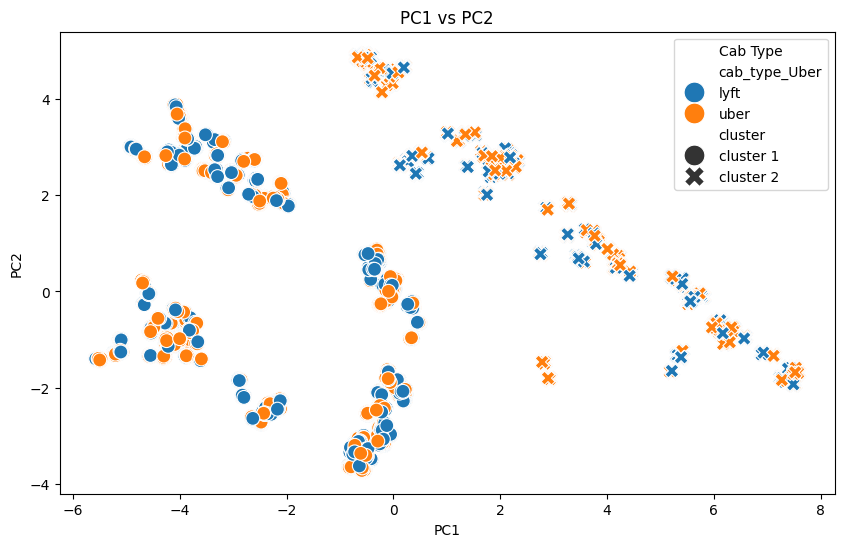

In [57]:
# Define colors and shapes for plotting
colors = {1: 'uber', 0: 'lyft'}
shapes = {0: 'cluster 1', 1: 'cluster 2'}  # Use square for cluster 0 and circle for cluster 1

# Map the 'cab_type' column to colors
colors_mapped = X_train_pca_labeled['cab_type_Uber'].map(colors)

# Map the 'cluster' column to shapes
shapes_mapped = X_train_pca_clustered['cluster'].map(shapes)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca['PC1'], y=X_train_pca['PC2'], hue=colors_mapped, style=shapes_mapped, s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.legend(title='Cab Type', loc='upper right', markerscale=1.5, fontsize='medium', labelspacing=0.5)
plt.show()

We can see from the plot above that the colors (Uber/Lyft) and the shapes (cluster 1 vs cluster 2) have little overlap. This suggests that Uber and Lyft are relatively indistinguishable based on our data.

In [58]:
# Get cluster labels
cluster_labels = kmeans.labels_

true_labels = y_train['cab_type_Uber']

# Compute misclassification error
misclassification_error = 1 - accuracy_score(true_labels, cluster_labels)
print("Misclassification error:", misclassification_error)

Misclassification error: 0.5062055095398132


We found the misclassification error above, which shows about a 50% misclassification error. This tells us that Uber and Lyft are quite indistinguishable. In terms of business analytics, this is a good sign for Lyft since Uber was a big player in the rideshare market originally, and Lyft's entrance into the market was originally slow, but steady. Over time, we can see that Lyft has risen to have very similar characteristics as Uber, becoming the second most popular rideshare app. This has allowed the company to price their services similar to Uber for rides that have similar features. We can see that from the fact that our PCA clustering model has a very hard time distinguishing between Uber and Lyft rides. Further, since the clustering model is quite simple, it might not be picking up on all of the interactions between the different variables.

Overall, the model might be too simple, overlooking complexities in feature interactions. Further, the PCA variance might explain other differences instead of company. Lastly, since PCs are linear combinations of features, it is hard to understand exactly what the PCs represent since they don't correspond to one specific metric or feature. We will improve on this model later on through a Random Forest, since that model has better interpretability (uses features rather than PCs), and incorporates more complexity.

## Part 6: Multiple Linear Regression for Price Prediction

We now switch gears to create a model that predicts price (continuous variable) rather than rideshare company (binary).

This model, unlike the previous PCA/clustering model, has the benefit of more interpretable results since we can see the beta values and p-values for specific features. This model better helps us understand what factors are important in determining price and how.

To do this, our first model will be a multiple regression, both with and without penalties. Our model seeks to find the relationship between other variables in order to predict the price of a given ride using linear relationships. Since multiple regression models allow us to inspect the beta values and p-values of each feature, we can better determine exactly which variables have positive or negative correlation with our outcome variable of price and by how much.

### Part 6.1: Multiple Regression with No Penalties

We used our Linear Regression model to run predictions for the training, testing, and validation datasets. We used unscaled data so that our beta-values are easily interpretable, i.e. a beta-value of X indicates that a one unit increase in that variable leads to a change of X in the response variable. We found the respective MSE and MAE values for each, printed below. Given that our mean price value is around $16, we note that these errors are pretty good, since on average, in the test set, the model is \$1.74 off from the correct price. This is thus a good first baseline model for price.

In [59]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_price, y_train_price)

# Predict on the training set
y_pred_train = model.predict(X_train_price)

# Compute the mean squared error on the train set
mse_train = mean_squared_error(y_train_price, y_pred_train)
print("Mean Squared Error on Train Set:", mse_train)

# Compute the mean absolute error on the train set
mae_train = mean_absolute_error(y_train_price, y_pred_train)
print("Mean Absolute Error on Train Set:", mae_train)

# Predict on the test set
y_pred_test = model.predict(X_test_price)

# Compute the mean squared error on the test set
mse_test = mean_squared_error(y_test_price, y_pred_test)
print("Mean Squared Error on Test Set:", mse_test)

# Compute the mean absolute error on the test set
mae_test = mean_absolute_error(y_test_price, y_pred_test)
print("Mean Absolute Error on Test Set:", mae_test)

Mean Squared Error on Train Set: 6.017215353414613
Mean Absolute Error on Train Set: 1.7314354559286314
Mean Squared Error on Test Set: 6.5514345214452945
Mean Absolute Error on Test Set: 1.7458034636531015


To investigate the beta values associated for each feature, we print out the coefficients along with feature names below.

In [60]:
# Get the beta values/coefficients
beta_values = model.coef_

# Get the names of the features
feature_names = X_train_price.columns

# Output the beta values for each feature
for feature, beta in zip(feature_names, beta_values):
    print(f"{feature}: {beta}")

timestamp: 9.392723418441928e-06
hour: -0.028893247580083936
day: -0.7710784966767388
month: -22.976060743042826
distance: 2.9053607098746452
latitude: -0.34454082360100413
longitude: -1.2372280336256845
temperature: 0.0011250274376309322
precipIntensity: 0.6168266521708745
humidity: 0.5042693236700034
windSpeed: 0.011131233208149072
visibility: -0.00392466376526307
temperatureHigh: -0.2156804966426703
temperatureHighTime: -1.1848278186454841e-05
temperatureLow: 0.023841899460099625
temperatureLowTime: 3.1760540759040445e-06
apparentTemperatureHigh: 0.0842346689978769
apparentTemperatureLow: -0.00685154539182431
pressure: 0.004897074772954424
windBearing: -6.275292025215151e-05
cloudCover: -0.24074497919289417
uvIndex: -0.013875656165115657
ozone: 0.0018929362068527134
precipIntensityMax: -0.6586234955527654
temperatureMin: 0.012224017783487362
temperatureMinTime: 5.227140622565685e-07
temperatureMax: 0.2281356795627545
temperatureMaxTime: 7.069827776540194e-06
apparentTemperatureMin: 

#### Part 6.1.1: PandaSQL for Positive and Negative Beta Values

We wanted to investigate which variables were positively or negatively correlated with price. This will give us a better sense of what affects price and how.

In [61]:
# Get the names of the features
feature_names = X_train_price.columns

# Create a DataFrame to store the feature names and beta values
beta_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': beta_values})

# PandaSQL environment
pysqldf = lambda q: sqldf(q, globals())

# Separate features with positive coefficients
positive_features_query = """
    SELECT *
    FROM beta_df
    WHERE Coefficient > 0
"""
positive_features_df = pysqldf(positive_features_query)

# Separate features with negative coefficients
negative_features_query = """
    SELECT *
    FROM beta_df
    WHERE Coefficient < 0
"""
negative_features_df = pysqldf(negative_features_query)

print("Features with positive coefficients")
positive_features_df

Features with positive coefficients


,Feature,Coefficient
0,timestamp,9.392723e-06
1,distance,2.905361e+00
2,temperature,1.125027e-03
3,precipIntensity,6.168267e-01
4,humidity,5.042693e-01
5,windSpeed,1.113123e-02
6,temperatureLow,2.384190e-02
7,temperatureLowTime,3.176054e-06
8,apparentTemperatureHigh,8.423467e-02
9,pressure,4.897075e-03


In [62]:
print("Features with negative coefficients")
negative_features_df

Features with negative coefficients


,Feature,Coefficient
0,hour,-0.028893
1,day,-0.771078
2,month,-22.976061
3,latitude,-0.344541
4,longitude,-1.237228
5,visibility,-0.003925
6,temperatureHigh,-0.215680
7,temperatureHighTime,-0.000012
8,apparentTemperatureLow,-0.006852
9,windBearing,-0.000063


We can see from the above that many of the variables that we expect to be positively correlated with price have positive beta values: distance, precipitation, special ride types (Lux, Lux Black, Black SUV), worse weather conditions (Overcast, Drizzle, Rain), high traffic locations (North End, North Station), and temperature (lower temperatures might cause lower demand, which means rideshare companies decrease price accordingly). On the other hand, many of the negatively correlated variables are also expected: ride types like UberPool/Shared and lower traffic areas, such as Beacon Hill and Fenway.

#### Part 6.1.2: Bar chart of top 5 lowest and highest coefficients

For a better visual representation, we use a bar chart to see the most positively and most negatively correlated variables with price. We can see that the ride types, like the luxury and shared types, affect the price significantly. We can see that the ride type matters the most, which makes sense because we know that companies price their services differently based on luxury rides, shared rides, and more. Further, it makes sense that distance is positively correlated with price so much because longer rides tend to be priced higher. Thus, these business insights tell us that companies can serve a wide range of customer base by providing a variety of services at different price points to engage customers with different levels of willingness to pay.

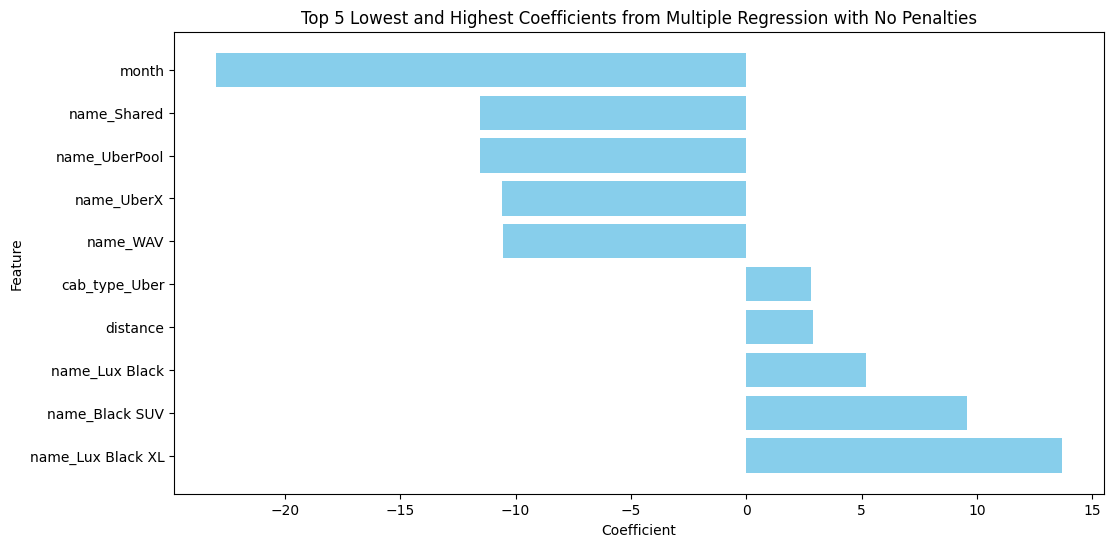

In [63]:
beta_df_sorted = beta_df.sort_values('Coefficient')

# Select the top 5 highest and top 5 lowest coefficient values
top_bottom_5 = pd.concat([beta_df_sorted.head(5), beta_df_sorted.tail(5)])

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_bottom_5['Feature'], top_bottom_5['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 5 Lowest and Highest Coefficients from Multiple Regression with No Penalties')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

#### Part 6.1.3: Summary of Multiple Regression Model

We next look to output a more comprehensive summary of the model which includes p-values to see feature significance in the model.

In [64]:
# Add a constant term to the features matrix for the intercept
X_train_price_with_const = sm.add_constant(X_train_price)

# Initialize and fit the model
model = sm.OLS(y_train_price, X_train_price_with_const)
results = model.fit()

# Print out the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     6180.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:18:14   Log-Likelihood:                -87529.
No. Observations:               37789   AIC:                         1.752e+05
Df Residuals:                   37717   BIC:                         1.758e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ti

From the summary of the multiple linear regression shown above, we can see the coefficients and p-values associated with each variable. We note that the lower p-value variables have higher significance in our model. The R^2 of our model is 0.923 and our F-stat is 6359.

#### Part 6.1.4: PandaSQL for Lowest p-value Features

 Finally, we output the lowest p-value features below to see the most relevant variables to this model. We print the top 15 relevant variables using PandaSQL.

In [65]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_price, y_train_price)

# Get the coefficients
coefficients = model.coef_

# Compute p-values using t-statistics

# Residuals
residuals = y_train_price - model.predict(X_train_price)

# Degrees of freedom
n = len(X_train_price)
p = X_train_price.shape[1]
df = n - p - 1

# Standard error of coefficients
std_err = np.sqrt(np.sum(residuals**2) / df)

# t-statistics
t_stats = coefficients / std_err

# Two-tailed p-values
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))

# Create a DataFrame to store coefficients and p-values
results_df = pd.DataFrame({'Feature': X_train_price.columns,
                           'Coefficient': coefficients,
                           'P-value': p_values})

# Sort df by p-value in decreasing order
results_df_sorted = results_df.sort_values(by='P-value', ascending=True)

# Initialize PandaSQL environment
pysqldf = lambda q: sqldf(q, globals())

# Sort df by p-value in decreasing order using PandaSQL
query = """
    SELECT *
    FROM results_df
    ORDER BY "P-value" ASC
"""
results_df_sorted = pysqldf(query)

# Output the head of the df
results_df_sorted.head(15)

,Feature,Coefficient,P-value
0,month,-22.976061,0.000000e+00
1,name_Lux Black XL,13.677328,2.561546e-08
2,name_Shared,-11.532835,2.651311e-06
3,name_UberPool,-11.522384,2.707055e-06
4,name_UberX,-10.594818,1.601273e-05
5,name_WAV,-10.542285,1.763632e-05
6,name_Black SUV,9.581823,9.545438e-05
7,name_Lyft,-7.938043,1.226714e-03
8,name_Lux Black,5.212315,3.378023e-02
9,name_UberXL,-4.821486,4.958452e-02


 The most significant variables were special ride types, distance, Uber/Lyft, longitude, and day.


Overall, we found an MAE of about 1.73 and 1.74 for train and test data respectively, and MSE was 6.02 and 6.55 for train and test data respectively. These errors suggest the model performs pretty well, since the average price is about $16. Since the error is a bit higher for the test data set, this suggests this model is slightly overfitted. Due to the lack of penalties, this model might be too complex and we use over 70 variables, so we next aim to reduce this complexity.

### Part 6.2: Multiple Regression with Parameter Grid Search

Since we saw overfitting in the regression with no penalty, we now aim to reduce model complexity through regularization (penalties). We use Grid Search for hyperparameter tuning and optimization for Ridge, LASSO, and Elastic Net models. Hyperparameter tuning is important to ensure that our model performs as optimally as we can get it. By using grid search, we can easily test various parameter combinations to identify which combination reduces our error.

We use grid search to optimize our alpha parameter along with Lasso, Ridge, and Elastic Net models. We output the cross validation score, MSE, and MAE for each.

In [66]:
# Ignore convergence warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='sklearn')

# Initialize the models
lasso = Lasso()
ridge = Ridge()
elastic_net = ElasticNet()

# Define parameter grid (higher alpha = higher penalization)
param_grid = {
    'alpha': [0.005, 0.1, 1.0]
}

# Define and conduct Grid Search
models = [(lasso, 'Lasso_L1'), (ridge, 'Ridge_L2'), (elastic_net, 'Elastic Net_L1_L2')]

for model, name in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train_price, y_train_price)

    # Get the best model
    globals()[f'best_model_{name}'] = grid_search.best_estimator_ = grid_search.best_estimator_

    best_model = globals()[f'best_model_{name}']

    # Evaluate the best model
    train_score = best_model.score(X_train_price, y_train_price)
    test_score = best_model.score(X_test_price, y_test_price)

    print("----------------------------------------")
    print(f'---------------{name}---------------')
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Training cross-validation score for {name}: {train_score}')
    print(f'Test cross-validation score for {name}: {test_score}')

    # Predict on the training set
    y_pred_train = best_model.predict(X_train_price)

    # Compute the mean squared error on the train set
    mse_train = mean_squared_error(y_train_price, y_pred_train)
    print(f'Mean Squared Error on Train Set for {name}:', mse_train)

    # Compute the mean absolute error on the train set
    mae_train = mean_absolute_error(y_train_price, y_pred_train)
    print("Mean Absolute Error on Train Set:", mae_train)

    # Predict on the test set
    y_pred_test = best_model.predict(X_test_price)

    # Compute the mean squared error on the test set
    mse_test = mean_squared_error(y_test_price, y_pred_test)
    print(f'Mean Squared Error on Test Set for {name}:', mse_test)

    # Compute the mean absolute error on the train set
    mae_test = mean_absolute_error(y_test_price, y_pred_test)
    print("Mean Absolute Error on Test Set:", mae_test)

----------------------------------------
---------------Lasso_L1---------------
Best parameters for Lasso_L1: {'alpha': 0.005}
Training cross-validation score for Lasso_L1: 0.9205790154408009
Test cross-validation score for Lasso_L1: 0.9144611799550766
Mean Squared Error on Train Set for Lasso_L1: 6.037727994843441
Mean Absolute Error on Train Set: 1.735037718877236
Mean Squared Error on Test Set for Lasso_L1: 6.566082600152701
Mean Absolute Error on Test Set: 1.7503334115870366
----------------------------------------
---------------Ridge_L2---------------
Best parameters for Ridge_L2: {'alpha': 1.0}
Training cross-validation score for Ridge_L2: 0.9208474492766785
Test cross-validation score for Ridge_L2: 0.9146543998893114
Mean Squared Error on Train Set for Ridge_L2: 6.017321165406148
Mean Absolute Error on Train Set: 1.7311797651133765
Mean Squared Error on Test Set for Ridge_L2: 6.551250760673086
Mean Absolute Error on Test Set: 1.745631613582216
----------------------------------

Ridge yielded the best performance of the 3, with cross-validation scores of 0.92/0.91 for train/test, and an MSE of 6.01/6.55 & MAE of 1.73/1.74. These errors are almost identical to the regression without penalty, despite the reduced complexity. But it still shows some overfitting. Overall, this model performed well, giving similar results but with less variables. However, it overlooks variable interactions.

To investigate further, we check out the beta values for each variable.

In [67]:
# Get the beta values/coefficients
beta_values = best_model_Ridge_L2.coef_

# Get the names of the features
feature_names = X_train_price.columns

# Output the beta values for each feature
for feature, beta in zip(feature_names, beta_values):
    print(f"{feature}: {beta}")

timestamp: 6.005846463063678e-07
hour: 0.002805552686072725
day: -0.009667908863535617
month: -0.1373166002305233
distance: 2.9050875519542743
latitude: -0.31981601999896464
longitude: -1.0938469369683426
temperature: 0.0010114751920725102
precipIntensity: 0.41525064892275215
humidity: 0.5018881530702303
windSpeed: 0.011116142894785378
visibility: -0.0038373941091641595
temperatureHigh: -0.19867351075730771
temperatureHighTime: -1.171740649575555e-05
temperatureLow: 0.022638527621377382
temperatureLowTime: 3.043756830217282e-06
apparentTemperatureHigh: 0.07374545091158496
apparentTemperatureLow: -0.006390305095528528
pressure: 0.004836239185662488
windBearing: -6.824365997817322e-05
cloudCover: -0.2337876306005328
uvIndex: -0.013606310990190716
ozone: 0.0019464688488241158
precipIntensityMax: -0.6271559295051727
temperatureMin: 0.010893906402805662
temperatureMinTime: 5.145947989245089e-07
temperatureMax: 0.21103602221485485
temperatureMaxTime: 7.056107726761822e-06
apparentTemperature

#### Part 6.2.1: PandaSQL for Positive and Negative Beta Values

We again use PandaSQL to distinguish between the positively and negatively correlated variables with price.

In [68]:
# Get the names of the features
feature_names = X_train_price.columns

# Create a DataFrame to store the feature names and beta values
beta_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': beta_values})

# PandaSQL environment
pysqldf = lambda q: sqldf(q, globals())

# Separate features with positive coefficients
positive_features_query = """
    SELECT *
    FROM beta_df
    WHERE Coefficient > 0
"""
positive_features_df = pysqldf(positive_features_query)

# Separate features with negative coefficients
negative_features_query = """
    SELECT *
    FROM beta_df
    WHERE Coefficient < 0
"""
negative_features_df = pysqldf(negative_features_query)

print("Features with positive coefficients")
positive_features_df

Features with positive coefficients


,Feature,Coefficient
0,timestamp,6.005846e-07
1,hour,2.805553e-03
2,distance,2.905088e+00
3,temperature,1.011475e-03
4,precipIntensity,4.152506e-01
5,humidity,5.018882e-01
6,windSpeed,1.111614e-02
7,temperatureLow,2.263853e-02
8,temperatureLowTime,3.043757e-06
9,apparentTemperatureHigh,7.374545e-02


In [69]:
print("Features with negative coefficients")
negative_features_df

Features with negative coefficients


,Feature,Coefficient
0,day,-0.009668
1,month,-0.137317
2,latitude,-0.319816
3,longitude,-1.093847
4,visibility,-0.003837
5,temperatureHigh,-0.198674
6,temperatureHighTime,-0.000012
7,apparentTemperatureLow,-0.006390
8,windBearing,-0.000068
9,cloudCover,-0.233788


#### Part 6.2.2: Bar chart of top 5 lowest and highest coefficients

We now print a bar chart of the top positively and negatively correlated variables. We can see that the ride type matters the most, which makes sense because we know that companies price their services differently based on luxury rides, shared rides, and more. Further, it makes sense that distance is positively correlated with price so much because longer rides tend to be priced higher. Thus, these business insights tell us that companies can serve a wide range of customer base by providing a variety of services at different price points to engage customers with different levels of willingness to pay.

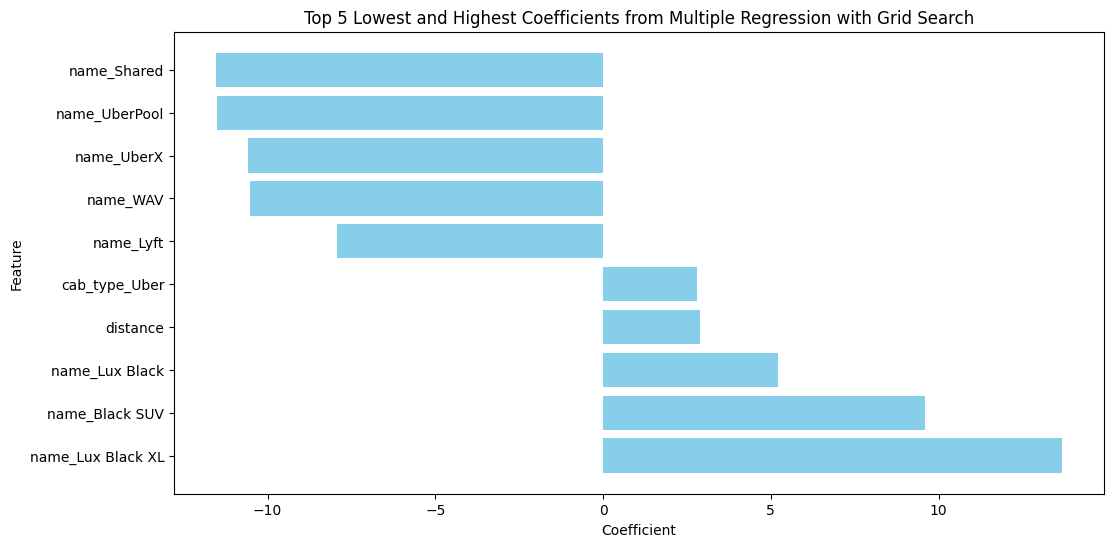

In [70]:
beta_df_sorted = beta_df.sort_values('Coefficient')

# Select the top 5 highest and top 5 lowest coefficient values
top_bottom_5 = pd.concat([beta_df_sorted.head(5), beta_df_sorted.tail(5)])

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_bottom_5['Feature'], top_bottom_5['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 5 Lowest and Highest Coefficients from Multiple Regression with Grid Search')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.show()

Overall, in this analysis of regularized multiple regression with penalties, Ridge yielded the best performance of the 3, with an MSE of 6.01/6.55 & MAE of 1.73/1.74. These errors are almost identical to the regression without penalty, despite the reduced complexity, but still shows some overfitting. Overall, this model performed well with fairly low errors, giving similar results as our previous model but with less variables. It also gives us very logical and interpretable results based on the bar chart above and the features' beta values. However, it overlooks variable interactions, which we will next aim to address.

## Part 7: Feedforward Neural Network (FNN) to Predict Price

We make an FNN that predicts price. Since our previous models do not investigate variable interactions as much, we now use a feedforward neural network on the scaled data to do so. The architecture uses several linear function layers and ReLU after each as the activation function. The last layer has 1 out feature to predict one variable (price). This will address the pitfalls of our previous model, multiple regression with and without penalties, which did not explore how the variables interact as much. Since neural networks constantly use linear combinations of the previous layer as input, and uses activation functions to allow for more complex relationships with the various linear combinations are combined, the neural network will provide a more powerful and complex approach to predicting price.

### Part 7.1: Centering, Scaling, and Tensor Creation

We now create tensors out of our scaled training and testing data. We then use DataLoader() in preparation for the neural network to be applied.

In [71]:
train_dataset = TensorDataset(torch.from_numpy(X_train_price_scaled).float(), torch.from_numpy(y_train_price_scaled).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(X_test_price_scaled).float(), torch.from_numpy(y_test_price_scaled).float())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Part 7.2: Defining FNN Architecture

Let's define the architecture. It uses four linear functions and ReLU functions in between. The neuron numbers are specified (64, 32, 16) The last layer has 1 out feature since we're predicting one variable (price).

In [72]:
# FNN architecture

class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=X_train_price.shape[1], out_features=64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=32, out_features=16)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

We now can get a written summary of our FNN's architecture:

In [73]:
FNN()

FNN(
  (fc1): Linear(in_features=74, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

### Part 7.3: Model training

Let's train our model on the training dataset. We use the CPU device to run our computations. We also use MSE loss as well as the Adam optimizer to optimize our parameters using loss.backward() and optimizer.step(). Further, we use 10 epochs and print the loss at each iteration.

In [74]:
# Sending the data to device (CPU or GPU)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Send the model to device
fnn = FNN()
fnn.to(device)
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-2) #lr - learning step
num_epochs = 10

# Example training loop
for epoch in range(num_epochs):
    fnn.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = fnn(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

Epoch 1/10, Loss: 1.0006369407810334
Epoch 2/10, Loss: 1.0002285096851098
Epoch 3/10, Loss: 1.0011024516447748
Epoch 4/10, Loss: 1.0003934930222087
Epoch 5/10, Loss: 1.0008019482222104
Epoch 6/10, Loss: 1.0006518011972585
Epoch 7/10, Loss: 1.0006300534693722
Epoch 8/10, Loss: 1.0003796392285884
Epoch 9/10, Loss: 1.000823668215279
Epoch 10/10, Loss: 1.00053189248603


### Part 7.4: Model testing

Let's test our model on the test data. We print the test loss afterward.

In [75]:
# Evaluate the test loss by running the neural net on test loader
fnn.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
      outputs = fnn(inputs)
      loss = loss_criterion(outputs, labels)
      test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

Test Loss: 1.009533126439367


We can see that we have a pretty high test loss of 1.01 for our scaled data. This suggests that our model performed relatively worse that our previous regression models, which had MSE values of 1.74 for the unscaled data. We can also see that the model is slightly overfitted. This performance might be low because there might be too much noise in the dataset and the model has trouble identifying patterns.

## Part 8: Random Forest Classifier with Grid Search to Predict Cab Type

Going back to our classification problem now, we want to build a more complex model than the simple clustering from earlier, and one that is more interpretable than PCs. Thus we use a more powerful model: Random Forest, removing special ride types (specific to Uber/Lyft, which would easily indicate to the model which company a ride is).

### Part 8.1: Initializing random forest classifier and parameter grid

We make a random forest to predict if any given ride is an Uber or Lyft, setting a seed of 1234.

In [76]:
# Set random seed
seed = 1234

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=seed)

Let's define our parameter grid that we'll search on. We try to opitmize the estimators, max depth, min samples split, and min samples leaf parameters.

In [77]:
# Input parameter values for the grid search to run on
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

### Part 8.2: Conducting grid search

Let's define our evaluator and cross-validator. We then train our data and save the best-performing model.

In [78]:
# Initialize the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Filter out columns starting with "name_"
X_train_filtered = X_train.loc[:, ~X_train.columns.str.startswith('name_')]
X_val_filtered = X_val.loc[:, ~X_val.columns.str.startswith('name_')]
X_test_filtered = X_test.loc[:, ~X_test.columns.str.startswith('name_')]

# Run grid search and find the best parameters
grid_search.fit(X_train_filtered, y_train)
best_params = grid_search.best_params_

# Use the best parameters for the final random forest model
final_rf = RandomForestClassifier(random_state=seed, **best_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


We now output the best parameters found by our grid search:

In [79]:
best_params

{'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 30}

### Part 8.3: Training and testing the random forest model (Accuracy, Recall, Precision)

We train the final model on the entire training set, then make predictions using the testing set. For each dataset, we print the accuracy, recall, and precision to see how well the model performs on them.

In [80]:
final_rf.fit(X_train_filtered, y_train)

y_train_pred = final_rf.predict(X_train_filtered)
training_accuracy = accuracy_score(y_train, y_train_pred)
training_recall = recall_score(y_train, y_train_pred)
training_precision = precision_score(y_train, y_train_pred)
print(f'Training Accuracy: {training_accuracy}')
print(f'Training Recall: {training_recall}')
print(f'Training Precision: {training_precision}')

y_val_pred = final_rf.predict(X_val_filtered)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Recall: {val_recall}')
print(f'Validation Precision: {val_precision}')

y_test_pred = final_rf.predict(X_test_filtered)
testing_accuracy = accuracy_score(y_test, y_test_pred)
testing_recall = recall_score(y_test, y_test_pred)
testing_precision = precision_score(y_test, y_test_pred)
print(f'Testing Accuracy: {testing_accuracy}')
print(f'Testing Recall: {testing_recall}')
print(f'Testing Precision: {testing_precision}')

Training Accuracy: 0.827383630156924
Training Recall: 0.9044050168247171
Training Precision: 0.7923795059632822
Validation Accuracy: 0.7226983688139342
Validation Recall: 0.8171489437244808
Validation Precision: 0.6993315101792769
Testing Accuracy: 0.7023386342376052
Testing Recall: 0.7945205479452054
Testing Precision: 0.6834108527131783


### Part 8.4: Confusion matrix on testing performance

We make a confusion matrix using our test data.

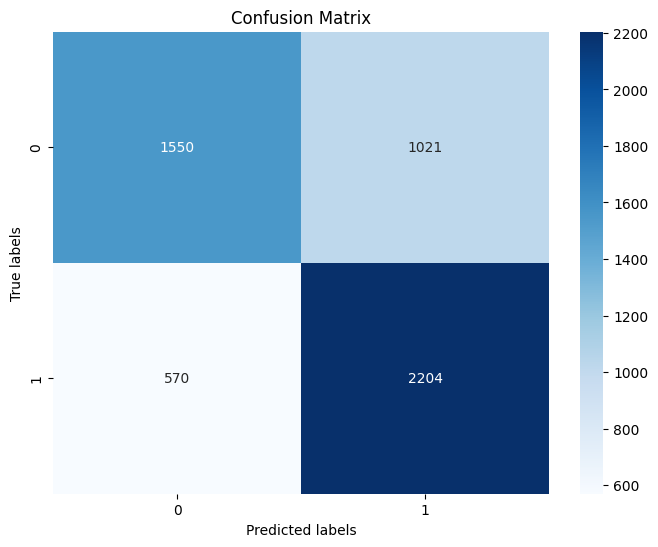

In [81]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Training accuracy of 82.7% with a recall of 90.4% and a precision of 79.2%, indicating that it is quite effective at identifying the correct class labels during training (high sensitivity), particularly in correctly predicting the majority class. However, in testing, accuracy dropped to 70.2%, with a recall of 79.5% and a precision of 68.3%, suggesting the model might be overfitted and thus performing less effectively on unseen data. Despite that, this model is much more accurate than our clustering, which had a 50% misclassification error, because the random forest has more complexity and is able to identify trends between the variables and how various features affect the company. We also see more interpretable results here since rather than PCs (linear combinations of multiple features), we can isolate specific features to evaluate their importance in distinguishing between rideshare companies.

### Part 8.5: Random forest feature importance

We now investigate which features were the most important for our model. This will give us a better understanding of the features that impact rideshare company. The visualization of a bar chart will make it easier to discern which features have higher impact and how much more.

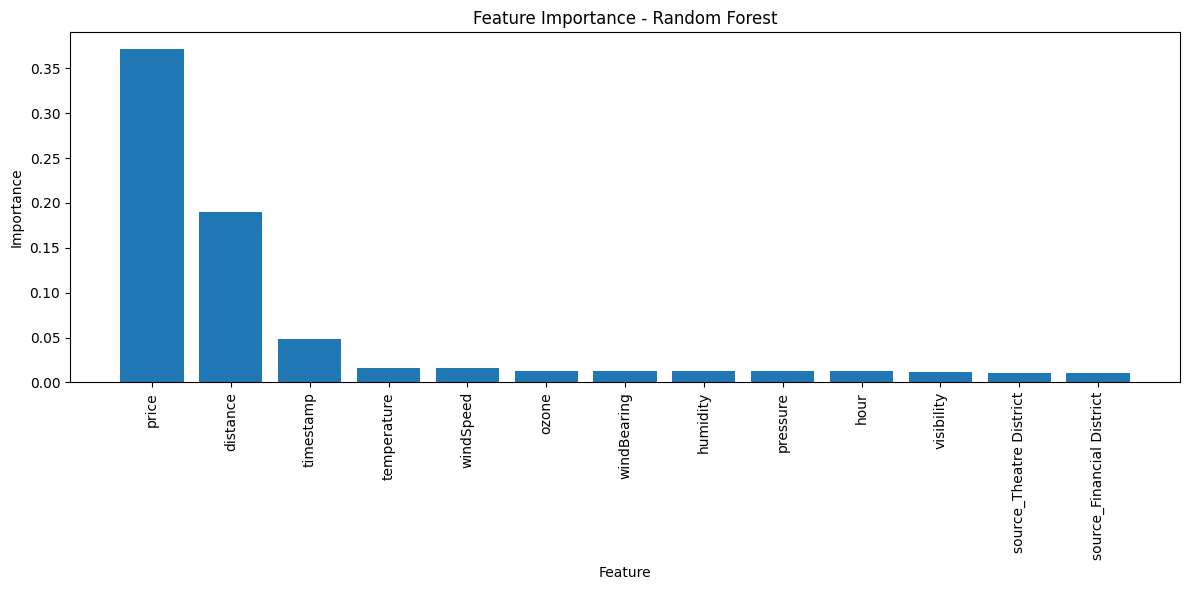

In [82]:
# Get feature importances from the model
feature_importances = final_rf.feature_importances_

# Get feature names
feature_names = X_train_filtered.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Select only the features that have values that are significantly high (i.e. non-zero or non-close to zero)
top_n = 13
sorted_feature_importances = sorted_feature_importances[:top_n]
sorted_feature_names = sorted_feature_names[:top_n]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

As we can see from the feature importance chart, the most important features for reducing entropy in the random forest were price and distance. This suggests that these are the features that distinguish Uber from Lyft the most. As we saw in our EDA, Lyft tends to have higher prices, which might be a feature that the Random Forest uses to distinguish between the companies.

In terms of business analytics, we can see that the companies are mostly aligned in most of the features of our dataset, which suggests a level playing field for both Uber and Lyft. This might suggest that Lyft has improved a lot as a competitor since entering the ridesharing business landscape.

## Part 9: Future Work

### Part 9.1: Challenges and Limitations

We think that our dataset had some limitations that hindered our ability to provide successful models. Our dataset was limited to just the Boston area, so it only picked up on urban rideshare patterns, and only had data from a limited 2 month timeframe. Exploring data from when Lyft had just entered the market would have more differentiation. It also only contained two of many rideshare companies.

### Part 9.2: Future Work and Models

For further analysis, a Boosting model might have improved accuracy and reduced bias due to its creation of strong learners for classifying rideshare companies. We could also try different achitectures for the neural network for optimization. Lastly, we could explore time series models.

### Part 9.3: Other Data

For future work, we would like to explore datasets that included data points from a wider timeframe (rather than just two months), and a wider geographic region (rather than just Boston). Since Boston is an urban location, analyzing more diverse data, such as in the suburbs or other parts of America, would increase the differentiation of our dataset, making it easier for our models to predict the outcome variables of rideshare company. This would also provide more generalizable and widespread insights. We could also use data that included not just Uber and Lyft, but also other rideshare companies. This would allows us to analyze other dynamics in the rideshare landscape, such as the comparative performance of smaller companies.

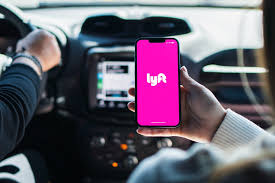

## Part 10: Conclusion

### Part 10.1: Summary of Results

Regression results: Most important factors for price were high traffic areas (North Station, North End), distance, special ride types (UberXL, Lux), and worse weather conditions (rain, overcast). Classification results: From our clustering, our model can’t distinguish b/w Uber/Lyft, suggesting Lyft has implemented good business tactics as a competitor. However, our random forest was better at classifying rides by rideshare company. Based on our EDA, we found that Lyft actually tends to have higher prices than Uber.

### Part 10.2: Model Performance

Based on our various models, we saw the best classification performance from the random forest model (80% recall, 70% accuracy) and the best regression performance from the Ridge regression model (MSE: 1.74). While some had overfitting, adjusting complexity helped hone in on key variables involved and improve interpretability.

### Part 10.3: Insights for Stakeholders

Consumers: Customers, such as college students, can use these insights to better predict when prices might be high. Since college students are very frequent users of ridesharing apps, this knowledge can better prepare them for what types of prices to expect when they are about to book a ride, and help them decide when to use Uber or Lyft and what factors might affect that. For instance, if the weather is quite bad on one day, they might be able to predict that rideshare prices might be very high, so they might opt for public transportation, like the Boston T system, which has less variance in their prices. Lastly, newcomers to certain areas in Boston, such as high traffic areas like North End and North Station, can better understand and predict which areas might have higher rideshare prices.

Businesses: Other emerging rideshare companies can look to Lyft’s successful business strategies to become a competitive player and be able to raise their prices similar to those of Uber. This would allow for the dynamics of various businesses in the rideshare landscape to learn how to get an edge over their other partners. Further, from our analyses we see that Uber and Lyft have been successful in catering to various price points for different customer bases, which has widened their appeal. This might be a good signal to emerging rideshare companies to also offer such a variety of services in order to have more profitable business model.

We hope our anaylses and insights provided you with a better picture of not only the rideshare landscape in Boston, but also some consumer and business insights that could be applied beyond!

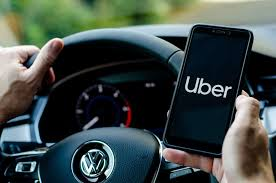